In [1]:
from numpy.random import Generator, PCG64
from numpy import unravel_index
import matplotlib.pyplot as plt
from copy import deepcopy
from random import sample
from enum import Enum
import pandas as pd
import numpy as np
import random 
random.seed(0)
import timeit
from operator import attrgetter
import math

In [2]:
import time
import multiprocessing as mp

# project packages
from models import SingleCustomer, LoadBalancer, Server, CustomerGroup, Status, Groups, ServerIDs, Statistics
from distributions import exponential_rng, homogeneous_poisson_process,\
homogeneous_poisson_process_variance_reduction

## Simulation
from simulation import handle_requests

## bootstrap
from bootstrap import bootstrap, moving_mean_var, test_bootstrap

## Scenario
from Scenario import Scenario

## utils -> get statistics
from utils import get_queue_statistics, get_statistics

## constants
from constants import MAX_CAPACITY, FIRST_ALLOCATION, SECOND_ALLOCATION

## Parameters for the simulations run: independent run, antithetic run
from SimulationParameters import SimulationParameters

## plot functions
from plot_functions import plot_queues, plot_empirical_mean_waiting_time

# Simulation

# First Run

The following two plots show the queue length over time, that is the number of users waiting, in the standard setting (without optimization).

In [3]:
def test_run(allocation: list, file_name: str):
    """
    Description:
        Run once the simulation
    Args:
        allocation (list) - The list of initial movies allocated to the ASNs
        file_name (str) - custom plot file name
    """
    scenario = Scenario(allocation, allocation)
    results, queues = handle_requests(scenario)
    statistics = get_statistics(results)
    plot_queues(queues, title=f'ASNs Movies Allocation: {allocation}', file_name=file_name)

MSN Customers Length: 5053    
ASN2 Customers Length: 1354   
ASN1 Customers Length: 2702   
4.502027333999999seconds to process all customers in three server


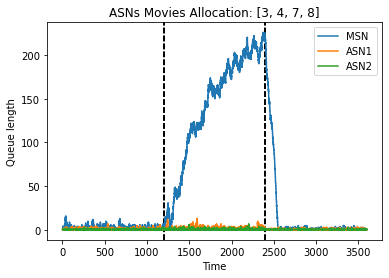

MSN Customers Length: 6058    
ASN2 Customers Length: 797    
ASN1 Customers Length: 2134   
7.362423936999999seconds to process all customers in three server


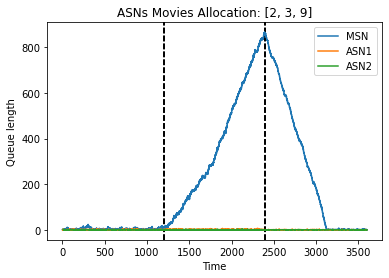

In [4]:
test_run(FIRST_ALLOCATION, file_name='first_allocation')
test_run(SECOND_ALLOCATION, file_name='second_allocation')

## Bootstraping

We are use bootstraping to improve our estimation of the true value. In this case we are applying the bootstrap technique to get a better estimation of the true mean waiting time.

In [5]:
#test_bootstrap(FIRST_ALLOCATION, file_name='first_allocation')  # UNCOMMENT LATER!
#test_bootstrap(SECOND_ALLOCATION, file_name='second_allocation')

## Variance Reduction

## 0. Independent Runs

In [6]:
def independent_runs(allocation: list):
    """
    Description:
        Parameters estimation, benchmark against antithetic runs and control variable
    Args:
        allocation (list) - The list of initial movies allocated to the ASNs
        file_name (str) - custom plot file name
    """
    t = 0
    scenario = Scenario(allocation, allocation)
    simulation_parameters = SimulationParameters()

    var = 0
    mean  = 0
    mean_waiting_time_all = []
    mean_waiting_time_mean_all = []
    mean_waiting_time_var_all = []
    while True: 
        t += 1

        # Run simulation
        results, _ = handle_requests(scenario)

        # Collect statistics
        statistics = get_statistics(results)


        mean_waiting_time = statistics['overall'][Statistics.mean.value]
        mean, var = moving_mean_var(
            mean_waiting_time,\
            mean,\
            var,\
            t
        )
  
        mean_waiting_time_all.append(mean_waiting_time)
        mean_waiting_time_mean_all .append(mean)
        mean_waiting_time_var_all.append(var)

        # Check if necessary precision reached
        if t >= simulation_parameters.run and np.sqrt(var / t) < simulation_parameters.precision:
            break
    
    return np.sqrt(mean_waiting_time_var_all)

## 1. Antithetic Runs

In [7]:
def antithetic_runs(allocation: list, scenario=None):
    t = 0
        # this is specified only if called from the optimization side
    if not scenario:
        scenario = Scenario(allocation, allocation)
    simulation_parameters = SimulationParameters()

    var = 0
    mean  = 0
    mean_waiting_time_all = []
    mean_waiting_time_mean_all = []
    mean_waiting_time_var_all = []
    
        
    #For optimization
    max_waiting_time = []
    average_waiting_time = []
    q75_waiting_time = []
    
    for i in np.arange(0, simulation_parameters.run/2): 
        t += 1

        # Run simulation (independent)
        u = np.random.rand(12, 15000)
        results, _ = handle_requests(scenario, u)


        # Run simulation (antithetic)
        u = 1 - u
        results_antithetic, _ = handle_requests(scenario, u)
        
        # Collect statistics
        statistics = get_statistics(results)
        statistics_antithetic = get_statistics(results_antithetic)
        ##################
        # For optimization
        ##################
        max_waiting_time.append(statistics['overall'][Statistics.max_.value])
        average_waiting_time = [statistics['overall'][Statistics.mean.value]]
        q75_waiting_time.append(statistics['overall'][Statistics.q75.value])
        mean_waiting_time = statistics['overall'][Statistics.mean.value]
        mean_waiting_time_antithetic = statistics_antithetic['overall'][Statistics.mean.value]
        
        mean_waiting_time = (mean_waiting_time + mean_waiting_time_antithetic) / 2
        mean, var = moving_mean_var(
            mean_waiting_time,\
            mean,\
            var,\
            t
        )

        mean_waiting_time_all.append(mean_waiting_time)
        mean_waiting_time_mean_all .append(mean)
        mean_waiting_time_var_all.append(var)
    # optimization
    statistics = dict()
    statistics['overall'] = dict()
    statistics['overall'][Statistics.mean.value] = np.mean(average_waiting_time)
    statistics['overall'][Statistics.max_.value] = np.mean(max_waiting_time)
    statistics['overall'][Statistics.q75.value] = np.mean(q75_waiting_time)
    
    return np.sqrt(mean_waiting_time_var_all), statistics

## 2. Controlled Mean

In [8]:
def controlled_mean(x, y, mu):
    """ Calculates the controlled mean.
    
    Keywords:
        x (array): Data.
        y (array): Control data.
        mu (float): Scalar expectation of the control data.
    
    Returns:
        avg (float): Controlled mean of the data.
        var (float): Variance of the controlled mean.
        z (array): Optimal linear combination of the data and the control data. 
    """

    cov = np.cov(x, y)
    cov_xy = cov[1, 0]
    var_y = cov[1, 1]
    
    c = -cov_xy / var_y
    z = x + c * (y - mu)
    
    avg = z.mean()
    var = z.var()
    
    return avg, var, z

In [9]:
def control_variate_runs(allocation: list, scenario=None):
    t = 0
    
    # this is specified only if called from the optimization side
    if not scenario:
        scenario = Scenario(allocation, allocation)
    simulation_parameters = SimulationParameters()
    
    var = 0
    mean  = 0
    mean_waiting_time_all = []
    mean_waiting_time_mean_all = []
    mean_waiting_time_var_all = []
    
    
    max_queue_length_all = []
    mean_waiting_time_control_all = []
    
    
    #For optimization
    max_waiting_time = []
    average_waiting_time = []
    q75_waiting_time = []
    
    #Main loop
    for j in np.arange(simulation_parameters.run):
        t += 1

        # Run simulation
        results, queue = handle_requests(scenario)
        # the maximum queue length for each group
        queue = get_queue_statistics(queue)
        # Collect statistics
        statistics = get_statistics(results)
        
        
        ##################
        # For optimization
        ##################
        max_waiting_time.append(statistics['overall'][Statistics.max_.value])
        average_waiting_time = [statistics['overall'][Statistics.mean.value]]
        q75_waiting_time.append(statistics['overall'][Statistics.q75.value])
        
        mean_waiting_time = statistics['overall'][Statistics.mean.value]
        mean, var = moving_mean_var(
            mean_waiting_time,\
            mean,\
            var,\
            t
        )
  
        mean_waiting_time_all.append(mean_waiting_time)
        mean_waiting_time_mean_all .append(mean)
        mean_waiting_time_var_all.append(var)
        
        mean_queue_length = (queue['overall']['max'] + queue['overall']['min']) / 2
        # Control the average waiting time
        if j:
            max_queue_length_all.append(mean_queue_length)
            _, var_control, _ = controlled_mean(
                np.array(mean_waiting_time_all),
                np.array(max_queue_length_all),
                0.5
            )
            mean_waiting_time_control_all.append(var_control)
        else:
            max_queue_length_all = [mean_queue_length]
            mean_waiting_time_control_all = [var]

    print(f'Correlation Matrix')
    print(f'{np.corrcoef(max_queue_length_all, mean_waiting_time_all)}')
    
    # optimization
    statistics = dict()
    statistics['overall'] = dict()
    statistics['overall'][Statistics.mean.value] = np.mean(average_waiting_time)
    statistics['overall'][Statistics.max_.value] = np.mean(max_waiting_time)
    statistics['overall'][Statistics.q75.value] = np.mean(q75_waiting_time)
    
    return np.sqrt(mean_waiting_time_var_all), statistics

In [10]:
# independent = independent_runs(FIRST_ALLOCATION)
# antithetic = antithetic_runs(FIRST_ALLOCATION)

In [11]:
# control_variate, _ = control_variate_runs(FIRST_ALLOCATION)

In [12]:
import matplotlib.pyplot as plt

In [13]:
# fig = plt.figure()
# ax = plt.subplot(1,1,1)

# ax.plot(independent, label='Std. dev. - independent runs')
# ax.plot(np.arange(0,len(independent),step=2), antithetic, label='Std. dev.- antithetic runs')
# ax.plot(control_variate, label='Std. dev. - control variate runs')
# ax.set(title='Waiting Time',
#        xlabel='Epoch',
#        ylabel='Average Waiting Time')
# ax.legend()
# fig.savefig('variance_reduction.pdf', dpi=300)
# plt.show()

# Optimization Part
------------------------------------------------------------

## 1. Solution Representation
--------------------------------

In [14]:
class Solution():
    
    """
    This class provides the solution representation which
    consists of two lists: one for the movies assigned to
    ASN 1 and one for the movies assigned to ASN 2. In this
    class we also keep the performance metrics associated
    with our solution representation. We have two different
    performance metrics:
        i)  Waiting time of clients
            --> in the form of the desired statistic (average, max, or q75)
        ii) Total size in MB used in ASN 1 and ASN 2
    """
    
    def __init__(self, movies_ASN1, movies_ASN2, wt_obj):
        
        """
        % Constructor
        
        @inputs:
        --------
        
        --> movies_ASN1: list, movies stored in ASN 1
        --> movies_ASN2: list, movies stored in ASN 2
        --> wt_obj: string, the desired waiting time statistic (average, max, or q75)
        """
        
        self.movies_ASN1 = movies_ASN1  
        self.movies_ASN2 = movies_ASN2
        self.scenario = Scenario(self.movies_ASN1, self.movies_ASN2)  # the link with the simulation part
        self.total_size = sum([self.scenario.movie_sizes[i] for i in self.movies_ASN1])
        self.total_size += sum([self.scenario.movie_sizes[i] for i in self.movies_ASN2])
        
        # Yoooooooooo, that's a lot!
        _, self.statistics = antithetic_runs(
            allocation=self.movies_ASN1, # dummy variable if scenario is specified
            scenario=self.scenario # for compatibility between simulation and optimization
        ) 
        
        self.wt_obj = wt_obj
        self.waiting_time = self.statistics['overall'][self.wt_obj]  # desired statistic
        
        # let's keep all statistics (average, max, 75) associated with the solution
        self.waiting_time_max = self.statistics['overall']['max']
        self.waiting_time_q75 = self.statistics['overall']['q75']
        self.waiting_time_average = self.statistics['overall']['average']

    def get_objectives(self):
        
        """
        % Returns the performance metrics we have.
        
        @inputs:
        --------
        
        --> None
        
        @outputs:
        ---------
        
        --> a tuple of two elements.
        
        Warning: 
        -------
        The second performance metric (objective), i.e.,
        total size, is only used in multi-objective opt.
        """
        
        return self.waiting_time, self.total_size
    
    def set_movies_ASN1(self, new_movies):
        
        """
        % It overrides the list of movies
        assigned to storage node ASN 1
        
        @inputs:
        --------
        
        --> new movies: list, new movies to stored in ASN 1
        
        @outputs:
        ---------
        
        --> %inplace%
        """
        
        self.movies_ASN1 = new_movies
    
    def set_movies_ASN2(self, new_movies):
        
        """
        % It overrides the list of movies
        assigned to storage node ASN 2
        
        @inputs:
        --------
        
        --> new movies: list, new movies to stored in ASN 2
        
        @outputs:
        ---------
        
        --> %inplace%
        """
        
        self.movies_ASN2 = new_movies
    
    def change_wt_obj(self, new_wt_obj):
        
        """
        % It changes the desired statistic of waiting time
        as given in the argument.
        
        @inputs:
        --------
        
        --> new_wt_obj: string, ("average", "max", or "q75")
        
        @outputs:
        ---------
        
        --> %inplace%
        """
        
        self.wt_obj = new_wt_obj
        self.waiting_time = self.statistics['overall'][self.wt_obj]

## 2. Initial Solution
----------------------------------------

In [15]:
def get_min_size_left(movie_ls):
    
    """
    % It returns the minimum movie size of the movies
    which are not placed in the given list of the movies
    as an argument.
    
    @inputs:
    --------
    
    --> movie_ls: list, list of movies
    
    @outputs:
    ---------
    
    --> integer
    """
    
    scenario = Scenario([], [])  # null scenario to reach some problem parameters (like movie sizes)
    left_movies = list(set(list(range(10))) - set(movie_ls))  # list of movies that are not placed
    return min([scenario.movie_sizes[i] for i in left_movies])  # the minimum size among them

def constructionHeuristic(wt_obj):
    
    """
    % This function applies a construction heuristic which tries to 
    assign most popular film-group combinations to appropriate servers
    considering the distance between selected groups and servers.
    
    @inputs:
    --------
    
    --> wt_obj: string, ("average", "max", or "q75")
    
    @outputs:
    ---------
    
    --> Solution object
    """
    
    movies1, movies2 = [], []
    size1, size2 = 0, 0 
    scenario = Scenario(movies1, movies2)
    popularity = np.array(deepcopy(scenario.popularities))
    while True:
        group_, movie_ = unravel_index(popularity.argmax(), popularity.shape)
        if popularity[group_, movie_]<0:  # it means that we examined all group-movie pairs.
            break                         # therefore, we can terminate the loop
        popularity[group_, movie_] = - 1  # not to draw the same argmax indexes again and again
        group_obj = None
        if group_ == 0:
            group_obj = CustomerGroup(Groups.Group_1.value, scenario.popularities[0],
                                      scenario.activity_patterns[0], scenario.distances_g1)
        elif group_ == 1:
            group_obj = CustomerGroup(Groups.Group_2.value, scenario.popularities[1],
                                      scenario.activity_patterns[1], scenario.distances_g2)
        elif group_ == 2:
            group_obj = CustomerGroup(Groups.Group_3.value, scenario.popularities[2],
                                      scenario.activity_patterns[2], scenario.distances_g3)
        best_server = group_obj.best_server_options()[0]  # find the best server considering the distances
        if best_server == 'ASN1' and size1+scenario.movie_sizes[movie_] <= 3500 and movie_ not in movies1:
            movies1.append(movie_)
            size1 += scenario.movie_sizes[movie_]
        if best_server == 'ASN2' and size2+scenario.movie_sizes[movie_] <= 3500 and movie_ not in movies2:
            movies2.append(movie_)
            size2 += scenario.movie_sizes[movie_]
        # let's check that it is still possible to insert a film without violating feasibility
        if size1+get_min_size_left(movies1)>3500 and size2+get_min_size_left(movies2)>3500:
            break
    return Solution(movies1, movies2, wt_obj)

def getRandomFeasibleSolution(wt_obj):
    
    """
    % Generates a random feasible solution
    
    @inputs:
    --------
    
    --> wt_obj: string, ("average", "max", or "q75")
    
    @outputs:
    ---------
    
    --> Solution object
    """
    
    movies1, movies2 = [], []
    size1, size2 = 0, 0 
    scenario = Scenario(movies1, movies2)
    while True:
        rand_ = random.uniform(0,1)  # to determine which ASN will be considered in the current iteration
        if rand_<=0.5:  # ASN 1
            movie_ = random.choice(list(set(list(range(10))) - set(movies1)))  # random movie for ASN 1
            if size1+scenario.movie_sizes[movie_]<=3500:
                movies1.append(movie_)
                size1 += scenario.movie_sizes[movie_]
        else:
            movie_ = random.choice(list(set(list(range(10))) - set(movies2)))  # random movie for ASN 2 
            if size2+scenario.movie_sizes[movie_]<=3500:
                movies2.append(movie_)
                size2 += scenario.movie_sizes[movie_]
        # let's check that it is still possible to insert a film without violating feasibility
        if size1+get_min_size_left(movies1)>3500 and size2+get_min_size_left(movies2)>3500:
            break
    return Solution(movies1, movies2, wt_obj)

## 3. Neighborhood Definitions
----------------------------------

In [16]:
def generateNewMovie_1(rg, movie_list):
    #From the starting point, randomly choose 1 movie to delete, 
    #Randomly choose 2, check size
    movie_sizes = [850,950,1000,1200,800,900,1000,750,700,1100]

    new_movie_list = movie_list.copy() # make a copy 
    n_new_movie = len(new_movie_list)
    n_movies = 10
    #delete
    c1 = rg.choice(range(0, n_new_movie))
    del new_movie_list[c1]

    # choose another two
    c1 = -1
    c2 = -1
    
    while ((c1 == -1) or (c2 == -1) or (c1 == c2) or (c1 in movie_list) or (c2 in movie_list)):
        c1 = int(np.floor(rg.random() * n_movies))
        c2 = int(np.floor(rg.random() * n_movies))
    
    # check size
    sum_movie_size = 0
    for i in new_movie_list:
        sum_movie_size += movie_sizes[i]
    if sum_movie_size + movie_sizes[c1] <= 3500:
        new_movie_list.append(c1)
        sum_movie_size += movie_sizes[c1]
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)
            
    else: 
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)

    new_movie_list.sort()
    return new_movie_list

def get_neighbor_1(rg, current_sol):
    
    """
    % It generates the candidate solution given solution in the arguments
    by using the function "generateNewMovie_1"
    
    @ outputs:
    ----------
    Solution object
    """
    
    movies_1, movies_2 = current_sol.movies_ASN1, current_sol.movies_ASN2
    new_movies_1 = generateNewMovie_1(rg, movies_1)
    new_movies_2 = generateNewMovie_1(rg, movies_2)
    return Solution(new_movies_1, new_movies_2, current_sol.wt_obj)   

In [17]:
def generateNewMovie_2(rg, movie_list):
    #From the starting point, randomly choose 2 movies to delete, 
    #Randomly choose 3, check size
    movie_sizes = [850,950,1000,1200,800,900,1000,750,700,1100]

    new_movie_list = movie_list.copy() # make a copy 
    n_new_movie = len(new_movie_list)
    n_movies = 10
    #delete
    c1 = rg.choice(range(0, n_new_movie))
    if n_new_movie > 1:
        c2 = rg.choice(range(0, n_new_movie))
        while (c2 == c1):
            c2 = rg.choice(range(0, n_new_movie))
        if c2 > c1:
            del new_movie_list[c2]
            del new_movie_list[c1]
        else:
            del new_movie_list[c1]
            del new_movie_list[c2]

    # choose another three
    c1 = -1
    c2 = -1
    c3 = -1
    while ((c1 == -1) or (c2 == -1) or (c3 == -1)
        or (c1 == c2) or (c1 == c3) or (c2 == c3)
        or (c1 in movie_list) or (c2 in movie_list) or (c3 in movie_list)):
        c1 = int(np.floor(rg.random() * n_movies))
        c2 = int(np.floor(rg.random() * n_movies))
        c3 = int(np.floor(rg.random() * n_movies))
    
    # check size
    sum_movie_size = 0
    for i in new_movie_list:
        sum_movie_size += movie_sizes[i]
    if sum_movie_size + movie_sizes[c1] <= 3500:
        new_movie_list.append(c1)
        sum_movie_size += movie_sizes[c1]
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)
            sum_movie_size += movie_sizes[c2]
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)
    else: 
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)
            sum_movie_size += movie_sizes[c2]
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)
        else:
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)

    new_movie_list.sort()
    return new_movie_list

def get_neighbor_2(rg, current_sol):
    
    """
    % It generates the candidate solution given solution in the arguments
    by using the function "generateNewMovie_2"
    
    @ outputs:
    ----------
    Solution object
    """
    
    movies_1, movies_2 = current_sol.movies_ASN1, current_sol.movies_ASN2
    new_movies_1 = generateNewMovie_2(rg, movies_1)
    new_movies_2 = generateNewMovie_2(rg, movies_2)
    return Solution(new_movies_1, new_movies_2, current_sol.wt_obj)   

In [18]:
def generateNewMovie_3(rg, movie_list):
    #From the starting point, randomly choose 3 movies to delete, 
    #Randomly choose 4, check size
    movie_sizes = [850,950,1000,1200,800,900,1000,750,700,1100]

    new_movie_list = movie_list.copy() # make a copy 
    n_new_movie = len(new_movie_list)
    n_movies = 10
    #delete
    c1 = rg.choice(range(0, n_new_movie))
    if n_new_movie > 1:
        c2 = rg.choice(range(0, n_new_movie))
        while (c2 == c1):
            c2 = rg.choice(range(0, n_new_movie))
    
        if n_new_movie > 2:
            c3 = rg.choice(range(0, n_new_movie))
            while ((c3 == c1) or (c3 == c2)):
                c3 = rg.choice(range(0, n_new_movie))
        
            for ele in sorted([c1,c2,c3], reverse = True): 
                del new_movie_list[ele]
        else:
            if c2 > c1:
                del new_movie_list[c2]
                del new_movie_list[c1]
            else:
                del new_movie_list[c1]
                del new_movie_list[c2]

    # choose another four
    c1 = -1
    c2 = -1
    c3 = -1
    c4 = -1
    while ((c1 == -1) or (c2 == -1) or (c3 == -1) or (c4 == -1)
        or (c1 == c2) or (c1 == c3) or (c2 == c3) or (c1 == c4) or (c2  == c4) or (c3 == c4)
        or (c1 in movie_list) or (c2 in movie_list) or (c3 in movie_list) or (c4 in movie_list)):
        c1 = int(np.floor(rg.random() * n_movies))
        c2 = int(np.floor(rg.random() * n_movies))
        c3 = int(np.floor(rg.random() * n_movies))
        c4 = int(np.floor(rg.random() * n_movies))
    
    # check size
    sum_movie_size = 0
    for i in new_movie_list:
        sum_movie_size += movie_sizes[i]
    if sum_movie_size + movie_sizes[c1] <= 3500:
        new_movie_list.append(c1)
        sum_movie_size += movie_sizes[c1]
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)
            sum_movie_size += movie_sizes[c2]
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)
                sum_movie_size += movie_sizes[c3]
                if sum_movie_size + movie_sizes[c4] <= 3500:
                    new_movie_list.append(c4)
    else: 
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)
            sum_movie_size += movie_sizes[c2]
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)
                sum_movie_size += movie_sizes[c3]
                if sum_movie_size + movie_sizes[c4] <= 3500:
                    new_movie_list.append(c4)
        else:
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)
                sum_movie_size += movie_sizes[c3]
                if sum_movie_size + movie_sizes[c4] <= 3500:
                    new_movie_list.append(c4)
            else:
                if sum_movie_size + movie_sizes[c4] <= 3500:
                    new_movie_list.append(c4)

    new_movie_list.sort()
    return new_movie_list

def get_neighbor_3(rg, current_sol):
    
    """
    % It generates the candidate solution given solution in the arguments
    by using the function "generateNewMovie_3"
    
    @ outputs:
    ----------
    Solution object
    """
    
    movies_1, movies_2 = current_sol.movies_ASN1, current_sol.movies_ASN2
    new_movies_1 = generateNewMovie_3(rg, movies_1)
    new_movies_2 = generateNewMovie_3(rg, movies_2)
    return Solution(new_movies_1, new_movies_2, current_sol.wt_obj)   

In [19]:
def binary_change(movie_list, i):
    
    """
    % Checks whether given movie is placed in the given
    movie list or not. If given remove it, otherwise adds it 
    unless it does not violate the feasibility (capacity constraint).
    
    @Input:
    -------
    movie_list: List, movie lists
    i: int, specific movie
    movie_sizes: dict
    
    @Output:
    --------
    A list
    """
    movie_sizes = [850,950,1000,1200,800,900,1000,750,700,1100]
    new_movie_list = deepcopy(movie_list)
    if i in new_movie_list:
        new_movie_list.remove(i)
    else:
        new_movie_list.append(i)
    
    if sum([movie_sizes[movie] for movie in new_movie_list]) > 3500:
        return movie_list
    else:
        return new_movie_list

def get_neighbor_4(rg, current_sol):
    
    """
    % It generates the candidate solution given solution in the arguments
    by using the function "generateNewMovie_4"
    
    @ outputs:
    ----------
    Solution object
    """
    movie_1, movie_2 = current_sol.movies_ASN1, current_sol.movies_ASN2
    sample1 = random.sample(movie_2, min(len(movie_2), 2))
    sample2 = random.sample(movie_1, min(len(movie_1), 2))
    best_neighbor, best_neighbor_val = None, np.inf
    for i in sample1:
        new_movie_1 = binary_change(movie_1, i)
        for j in sample2:
            new_movie_2 = binary_change(movie_2, j)
            candidate = Solution(new_movie_1, new_movie_2, current_sol.wt_obj)
            candidate_val, _ = candidate.get_objectives()
            if candidate_val < best_neighbor_val:
                best_neighbor, best_neighbor_val = candidate, candidate_val
    if best_neighbor is not None:
        return best_neighbor
    else:
        return current_sol

## 4. Single objective
------------------------------------------------------------------------------------------------------------------

### 4.1. Helpers

In [20]:
def temperature_update(init, i, iterations):
        """
        % It returns an updated version of the 
        temperature value
        
        @inputs:
        --------
        --> init: float, initial temperature value
        --> i: int, current iterations number
        --> iterations: int, total number of iterations
        
        @outputs:
        ---------
        --> updated temperature value, float
        """
        p_0 = 0.999
        p_f = 0.001
        return -init/np.log(p_0+(p_f-p_0)/iterations*i)

In [21]:
def get_candidate_solution(rg, given_solution, which_neighbor):
    """
    % It generates a neighborhood of the given solution with respect to
      the desired neighborhood definition.
      
    @inputs:
    --------
    rg: random number generator
    given solution: Solution object, current solution
    which_neighbor: int, desired neighborhood definition
                    1 --> neighborhood definition 1
                    2 --> neighborhood definition 2
                    3 --> neighborhood definition 3
                    4 --> neighborhood definition 4
    wt_obj: string, ("average", "max", or "q75")
    
    @output:
    --------
    Solution object, neighborhood solution
    """
    
    if which_neighbor == 1:
        return get_neighbor_1(rg, given_solution)
    elif which_neighbor == 2:
        return get_neighbor_2(rg, given_solution)
    elif which_neighbor == 3:
        return get_neighbor_3(rg, given_solution)
    elif which_neighbor == 4:
        return get_neighbor_4(rg, given_solution)
    else:
        raise ValueError("Should be 1,2,3, or 4!")

### 4.2. Base Class

In [22]:
class AlgorithmSingleObjective(object):

    """
    This class provides basis for the
    algorithms used in  single-obj 
    optimization part. 
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj):
        
        """
        % Constructor function
        
        @inputs:
        --------
        --> rg: random number generator
        --> initial_solution: Solution object, the initial solution to initiate search
        --> n_iteration: int, the maximum number of iterations for our algorithms
        --> wt_obj: string, ("average", "max", or "q75")
        """
        
        self.rg = rg  
        self.initial_solution = initial_solution
        self.n_iteration = n_iteration
        self.wt_obj = wt_obj    
        self.best_solution = deepcopy(self.initial_solution)
        self.best_value, _ = self.initial_solution.get_objectives()
        self.algorithm_name = None
        self.time = None
        
        self.history_bestsol = []      # keeps track of best solutions over the iterations
        self.history_currentsol = []   # keeps track of current solutions over the iterations
        self.history_candidatesol = [] # keeps track of candidate solutions over the iterations
        
        # keep all statistics associated with the best found solution
        self.best_value_max = None
        self.best_value_average = None
        self.best_value_q75 = None
        # the three statistics above will be updated once the algorithm
        # returns its best found solution

### 4.3. Local Search

In [23]:
class LocalSearch(AlgorithmSingleObjective):
    
    """
    Inherited from AlgorithmSingleObjective class to implement Local Search
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj):
        
        """
        % constructor
        
        @Inputs:
        --------
        
        --> rg: random number generator
        --> initial_solution: Solution object, initial solution for heuristics
        --> n_iteration: int, maximum number of iterations allowed
        --> wt_obj: string, ("average", "max", or "q75")
        """
        
        AlgorithmSingleObjective.__init__(self, rg, initial_solution, n_iteration, wt_obj)
        self.algorithm_name = "LocalSearch"
    
    def run(self, which_neighbor):
        
        """
        Runs the local search algorithm considering the given neighborhood definition
        
        @inputs:
        -------
        
        --> which_neighbor: int, 1,2,3, or 4
        
        @outputs:
        ---------
        
        --> %inplace% 
        """
        start_time = timeit.default_timer()
        for i in range(self.n_iteration):
            print('iteration ', i+1)
            candidate_solution = get_candidate_solution(self.rg, self.best_solution, which_neighbor)
            candidate_value, _ = candidate_solution.get_objectives()
            self.history_candidatesol.append(candidate_value)
            if candidate_value < self.best_value:
                self.best_solution = candidate_solution
                self.best_value = candidate_value
            self.history_bestsol.append(self.best_value)
        end_time = timeit.default_timer()
        self.time = end_time - start_time
        self.best_value_max = self.best_solution.waiting_time_max
        self.best_value_average = self.best_solution.waiting_time_average
        self.best_value_q75 = self.best_solution.waiting_time_q75
    
    def plot_ls(self, which_neighbor, which_run=None, randomm_init_sol=False):
      
        """
        Plots the history of local search.
        """
        iterations = list(range(1, self.n_iteration+1))
        fig,ax = plt.subplots(figsize=(12,7))
        ax.set_xlabel("Iteration Number", fontsize=12)
        ax.set_ylabel("Candidate Solution Objective Function Value", fontsize=12)
        ax.set_xticks(list(range(1, self.n_iteration+1)))
        ax2 = ax.twinx()
        ax.plot(iterations, self.history_candidatesol, color='blue', label='Candidate Solution', marker='o')
        ax2.plot(iterations, self.history_bestsol, color='red', label='Best Solution',marker='o')
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')
        ax2.set_ylabel("Best Solution Objective Function Value", fontsize=12)
        if randomm_init_sol is False:
            title_ = "Local Search with Neighborhood Definition " + str(which_neighbor)
        else:
            title_ = "Local Search with Neighborhood Definition " + str(which_neighbor) + " & Random Initial Solution"
        plt.title(title_, fontsize=16)
        dir_ = "plots/optimization/local_search_experiment/"
        if randomm_init_sol is False:
            if which_run is None:
                dir_ += "ls_" + str(which_neighbor) + ".pdf"
            else:
                dir_ += "ls_" + str(which_neighbor) + "_" + str(which_run) + ".pdf"
        else:
            if which_run is None:
                dir_ += "rnd_ls_" + str(which_neighbor) + ".pdf"
            else:
                dir_ += "rnd_ls_" + str(which_neighbor) + "_" + str(which_run) + ".pdf"
        plt.savefig(dir_)

### 4.4. Simulated Annealing

In [24]:
class SimulatedAnnealing(AlgorithmSingleObjective):
    
    """
    Inherited from AlgorithmSingleObjective class to implement Simulated Annealing
    """
    def __init__(self, rg, initial_solution, n_iteration, wt_obj, temp_init=1):
        
        """
        % constructor function
        
        @Inputs:
        --------
        
        --> rg: random number generator
        --> initial_solution: Solution object, initial solution for heuristics
        --> n_iteration: int, maximum number of iterations allowed
        --> wt_obj: string, ("average", "max", or "q75")
        --> temp_init: float (optinal), initial temperature value
        """
        AlgorithmSingleObjective.__init__(self, rg, initial_solution, n_iteration, wt_obj)
        self.temp_init = temp_init
        self.algorithm_name = "SimulatedAnnealing"
    
    def run(self, which_neighbor):
        
        """
        Runs the simulated annealing algorithm considering the given neighborhood definition
        
        @inputs:
        -------
        
        --> which_neighbor: int, 1,2,3, or 4
        
        @outputs:
        ---------
        
        --> %inplace% 
        """
        
        start_time = timeit.default_timer()
        current_solution = deepcopy(self.initial_solution)
        for i in range(self.n_iteration):
            # print('iteration ', i+1)
            candidate_solution = get_candidate_solution(self.rg, current_solution, which_neighbor)
            candidate_value, _ = candidate_solution.get_objectives()
            self.history_candidatesol.append(candidate_value)
            current_temperature = temperature_update(self.temp_init, i, self.n_iteration)
            diff = candidate_value - self.best_value
            
            if diff<0:  # then update both best found solution and the current solution
                current_solution = deepcopy(candidate_solution)
                self.best_solution = deepcopy(candidate_solution)
                self.best_value = candidate_value
            else:
                if self.rg.random() < np.exp(-diff/current_temperature):  # then only update the current solution
                    current_solution = deepcopy(candidate_solution)
            self.history_bestsol.append(self.best_value)
            self.history_currentsol.append(current_solution.get_objectives()[0])
        end_time = timeit.default_timer()
        self.time = end_time - start_time
        self.best_value_max = self.best_solution.waiting_time_max
        self.best_value_average = self.best_solution.waiting_time_average
        self.best_value_q75 = self.best_solution.waiting_time_q75
        
    def plot_sa(self, which_neighbor, which_run=None, randomm_init_sol=False):
        """
        Plots the history of simulated annealing.
        """
        
        iterations = list(range(1, self.n_iteration+1))
        fig,ax = plt.subplots(figsize=(12,7))
        ax.set_xlabel("Iteration Number", fontsize=12)
        ax.set_ylabel("Objective Function Value", fontsize=12)
        ax.set_xticks(list(range(1, self.n_iteration+1)))
        ax2 = ax.twinx()
        ax.plot(iterations, self.history_candidatesol, color='blue', label='Candidate Solution', marker='o')
        ax.plot(iterations, self.history_currentsol, color='green', label='Current Solution', marker='o')
        ax2.plot(iterations, self.history_bestsol, color='red', label='Best Solution',marker='o')
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')
        ax2.set_ylabel("Best Solution Objective Function Value", fontsize=12)
        if randomm_init_sol is False:
            title_ = "Simulated Annealing with Neighborhood Definition " + str(which_neighbor)
        else:
            title_ = "Simulated Annealing with Neighborhood Definition " + str(which_neighbor) + " & Random Initial Solution"
        plt.title(title_, fontsize=16)
        dir_ = "plots/optimization/simulated_annealing_experiment/"
        if randomm_init_sol is False:
            if which_run is None:
                dir_ += "sa_" + str(which_neighbor) + ".pdf"
            else:
                dir_ += "sa_" + str(which_neighbor) + "_" + str(which_run) + ".pdf"
        else:
            if which_run is None:
                dir_ += "rnd_sa_" + str(which_neighbor) + ".pdf"
            else:
                dir_ += "rnd_sa_" + str(which_neighbor) + "_" + str(which_run) + ".pdf"
        plt.savefig(dir_)


### 4.5. Variable Neighborhood Search (VNS)

In [25]:
class VNS(AlgorithmSingleObjective):
    """
    Inherited from AlgorithmSingleObjective class to implement Variable Neighborhood Search
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj, k_neighborhoodStrategy=4):
        """
        % constructor function
        
        @Inputs:
        --------
        
        --> rg: random number generator
        --> initial_solution: Solution object, initial solution for heuristics
        --> n_iteration: int, maximum number of iterations allowed
        --> wt_obj: string, ("average", "max", or "q75")
        --> k_neighborhoodStrategy: int (optinal)
        """
        
        AlgorithmSingleObjective.__init__(self, rg, initial_solution, n_iteration, wt_obj)
        self.k_neighborhoodStrategy = k_neighborhoodStrategy
        self.algorithm_name = "VNS"
        self.history_k = []
    
    def run(self):
        """
        % Runs VNS
        """
        
        n_iter = 0
        k = 1
        start_time = timeit.default_timer()
        while n_iter < self.n_iteration:
            while True:
                # print('iter: ', n_iter, 'k', k)
                best_candidate = get_candidate_solution(self.rg, self.best_solution, k)
                best_candidate_val,_ = best_candidate.get_objectives()
                n_iter +=1
                self.history_candidatesol.append(best_candidate_val)
                self.history_k.append(k)
                if best_candidate_val < self.best_value:
                    self.best_solution = best_candidate
                    self.best_value = best_candidate_val
                    self.history_bestsol.append(self.best_value)
                else:
                    self.history_bestsol.append(self.best_value)
                    break
                if n_iter >= self.n_iteration:
                    break
            k += 1
            if k == self.k_neighborhoodStrategy+1:
                k = 1  # ***
        # *** We let the algorithm to return the first neighborhood definition unless 
        # it reaches to the maximum number of iterations, as it allows us to increase
        # the level of diversification by including randomness.
        end_time = timeit.default_timer()
        self.time = end_time - start_time
        self.best_value_max = self.best_solution.waiting_time_max
        self.best_value_average = self.best_solution.waiting_time_average
        self.best_value_q75 = self.best_solution.waiting_time_q75
                
    def plot_vns(self, which_run=None, randomm_init_sol=False):
        
        """
        Plots the history of VNS.
        """
        
        iterations = list(range(1, self.n_iteration+1))
        fig,ax = plt.subplots(figsize=(12,7))
        ax.set_xlabel("Iteration Number", fontsize=12)
        ax.set_ylabel("Objective Function Value", fontsize=12)
        ax.set_xticks(list(range(1, self.n_iteration+1)))
        ax2 = ax.twinx()
        ax.plot(iterations, self.history_candidatesol, color='blue', label='Candidate Solution', marker='o')
        ax2.plot(iterations, self.history_bestsol, color='red', label='Best Solution',marker='o')
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')
        ax2.set_ylabel("Best Solution Objective Function Value", fontsize=12)
        if randomm_init_sol is False:
            title_ = "VNS"
        else:
            title_ = "VNS with Random Initial Solution"

        plt.title(title_, fontsize=16)
        dir_ = "plots/optimization/vns_experiment/"
        
        
        if randomm_init_sol is False:
            if which_run is None:
                dir_ += "vns.pdf"
            else:
                dir_ += "vns_" + str(which_run) + ".pdf"
        else:
            if which_run is None:
                dir_ += "rnd_vns.pdf"
            else:
                dir_ += "rnd_vns_" + str(which_run) + ".pdf"
            
        plt.savefig(dir_)

## 5.Multi-objective Optimization
--------------------------------------------------------------------------------------------

### 5.1. Helpers

In [26]:
# Pareto dominance
def improvement(solution_old, solution_new):
    
    """
    % It checks whether new solution dominates
    the old solution or not
    
    @inputs:
    --------
    --> solution_old: Solution object, old solution
    --> solution_new: Solution object, new solution
    
    @outputs:
    --------
    --> true if new solution dominates; false, otherwise
    """
    rule_1, rule_2 = False, False
    
    waiting_time_old, total_size_old = solution_old.get_objectives()
    waiting_time_new, total_size_new = solution_new.get_objectives()
    
    if waiting_time_new <= waiting_time_old and total_size_new <= total_size_old:
        rule_1 = True
        
    if waiting_time_new < waiting_time_old or total_size_new < total_size_old:
        rule_2 = True

    return rule_1 and rule_2

### 5.2. Base Class

In [27]:
class AlgorithmMultiObjective(object):

    """
    This class provides basis for the
    algorithms used in  multi-obj 
    optimization part. 
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj):
        
        """
        % Constructor function
        
        @inputs:
        --------
        --> rg: random number generator
        --> initial_solution: Solution object, the initial solution to initiate local search
        --> n_iteration: int, the maximum number of iterations for our algorithms
        --> wt_obj: string, ("average", "max", or "q75")
        """
        
        self.rg = rg  
        self.initial_solution = initial_solution
        self.n_iteration = n_iteration
        self.wt_obj = wt_obj    
        
        self.algorithm_name = None
        self.time = None
        
        self.pareto_frontier = [deepcopy(self.initial_solution)]
        self.considered = []
        self.removed = []
        
    def plot(self, which_neighbor=None, which_run=None):
        """
        % plots history of multi-objective optimization algorithm
        """
        plt.figure(figsize=(12,7))
        plt.scatter([sol.total_size for sol in self.considered],
                    [sol.waiting_time for sol in self.considered],
                    label="considered", c='blue',s=50)
        plt.scatter([sol.total_size for sol in self.pareto_frontier],
                    [sol.waiting_time for sol in self.pareto_frontier],
                    label="Pareto", c='red', s=50)  
        plt.scatter([sol.total_size for sol in self.removed],
                    [sol.waiting_time for sol in self.removed],
                    label="Removed", c='orange', s=50) 
        plt.xlabel("Total Size")
        plt.ylabel("Waiting Time")
        plt.legend()
        if self.algorithm_name == "LocalSearchMultiObj":
            plt.title("Local Search with Neighborhood Definition " + str(which_neighbor), fontsize=16)
            dir_ = "plots/optimization/multiobjective/local_search_experiment/"
            if which_run is None:
                dir_ += "mols_" + str(which_neighbor) + ".pdf"
            else:
                dir_ += "mols_" + str(which_neighbor) + "_" + str(which_run) + ".pdf"
        elif self.algorithm_name == "VNSMultiObj":
            plt.title("Variable Neighborhood Search", fontsize=16)
            dir_ = "plots/optimization/multiobjective/vns_experiment/"
            if which_run is None:
                dir_ += "movns.pdf"
            else:
                dir_ += "movns_" + str(which_run) + ".pdf"
        plt.savefig(dir_)


### 5.3. Local Search

In [28]:
class LocalSearchMultiObj(AlgorithmMultiObjective):
    
    """
    Inherited from AlgorithmMultiObjective class to implement Local Search
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj):
        
        """
        % constructor function
        
        @inputs:
        --------
        --> rg: random number generator
        --> initial_solution: Solution object, the initial solution to initiate local search
        --> n_iteration: int, the maximum number of iterations for our algorithms
        --> wt_obj: string, ("average", "max", or "q75")
        """
        
        AlgorithmMultiObjective.__init__(self, rg, initial_solution, n_iteration, wt_obj)
        self.algorithm_name = "LocalSearchMultiObj"
        
    def run(self, which_neighbor):
        
        """
        Runs the local search algorithm
        """
        start_time = timeit.default_timer()
        for i in range(self.n_iteration):
            # print('iteration ', i+1)
            x = random.choice(self.pareto_frontier)
            candidate_solution = get_candidate_solution(self.rg, x, which_neighbor)
            if candidate_solution in self.pareto_frontier:
                continue
            D = [i for i in self.pareto_frontier if improvement(i, candidate_solution)]
            S = [i for i in self.pareto_frontier if improvement(candidate_solution, i)]
            if len(S)==0:
                self.pareto_frontier.append(candidate_solution)
                for i in D:
                    self.pareto_frontier.remove(i)
                    self.removed.append(i)
            else:
                self.considered.append(candidate_solution)
        end_time = timeit.default_timer()
        self.time = end_time - start_time

### 5.4. VNS

In [29]:
class VNSMultiObj(AlgorithmMultiObjective):
    
    """
    Inherited from AlgorithmMultiObjective class to implement Variable Neighborhood Search
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj, k_neighborhoodStrategy=4):
        """
        % constructor function
        
        @inputs:
        --------
        --> rg: random number generator
        --> initial_solution: Solution object, the initial solution to initiate local search
        --> n_iteration: int, the maximum number of iterations for our algorithms
        --> wt_obj: string, ("average", "max", or "q75")
        --> k_neighborhoodStrategy: int, optional
        """
        AlgorithmMultiObjective.__init__(self, rg, initial_solution, n_iteration, wt_obj)
        self.k_neighborhoodStrategy = k_neighborhoodStrategy
        self.algorithm_name = "VNSMultiObj"
        self.history_k = []
    
    def run(self):
        
        """
        Runs VNS for multi-objective case
        """
        n_iter = 0
        k = 1
        start_time = timeit.default_timer()
        while n_iter < self.n_iteration:
            while True:
                print('iter: ', n_iter, 'k', k)
                x = random.choice(self.pareto_frontier)
                candidate = get_candidate_solution(self.rg, x, k)
                if candidate in self.pareto_frontier:
                    continue
                candidate_val,_ = candidate.get_objectives()
                n_iter +=1
                self.history_k.append(k)
                D = [i for i in self.pareto_frontier if improvement(i, candidate)]
                S = [i for i in self.pareto_frontier if improvement(candidate, i)]
                if len(S)==0:
                    self.pareto_frontier.append(candidate)
                    for i in D:
                        self.pareto_frontier.remove(i)
                        self.removed.append(i)
                else:
                    self.considered.append(candidate)
                    break
                if n_iter >= self.n_iteration:
                    break
            k += 1
            if k == self.k_neighborhoodStrategy+1:
                k = 1  # ***
        # *** We let the algorithm to return the first neighborhood definition unless 
        # it reaches to the maximum number of iterations, as it allows us to increase
        # the level of diversification by including randomness.
        end_time = timeit.default_timer()
        self.time = end_time - start_time

# Experiments

## Comparing Different Objectives

### For single objectives

In [30]:
# init_sol = getRandomFeasibleSolution("average")
# rg_ = Generator(PCG64(42069))
# n_iteration = 5

#### Local Search

In [31]:
"""
local_search_average = LocalSearch(rg_, init_sol, n_iteration, wt_obj='average')
local_search_average.run(which_neighbor=1)

init_sol.change_wt_obj("max")
local_search_max = LocalSearch(rg_, init_sol, n_iteration, wt_obj='max')
local_search_max.run(which_neighbor=1)

init_sol.change_wt_obj("q75")
local_search_q75 = LocalSearch(rg_, init_sol, n_iteration, wt_obj='q75')
local_search_q75.run(which_neighbor=1)
"""

'\nlocal_search_average = LocalSearch(rg_, init_sol, n_iteration, wt_obj=\'average\')\nlocal_search_average.run(which_neighbor=1)\n\ninit_sol.change_wt_obj("max")\nlocal_search_max = LocalSearch(rg_, init_sol, n_iteration, wt_obj=\'max\')\nlocal_search_max.run(which_neighbor=1)\n\ninit_sol.change_wt_obj("q75")\nlocal_search_q75 = LocalSearch(rg_, init_sol, n_iteration, wt_obj=\'q75\')\nlocal_search_q75.run(which_neighbor=1)\n'

In [32]:
"""
x = {'Average':[local_search_average.best_value_average,
                local_search_max.best_value_average,
                local_search_q75.best_value_average],
     'Max':[local_search_average.best_value_max,
            local_search_max.best_value_max,
            local_search_q75.best_value_max,],
     'Q75': [local_search_average.best_value_q75,
             local_search_max.best_value_q75,
             local_search_q75.best_value_q75]}

LS_Objs = pd.DataFrame(x)
LS_Objs.index = ['Average', 'Max', 'Q75']

print("\033[1m Local Search \033[0m")
print("\033[3m each row demonstrates the objective function and each column shows the results \033[0m")
display(LS_Objs)
"""

'\nx = {\'Average\':[local_search_average.best_value_average,\n                local_search_max.best_value_average,\n                local_search_q75.best_value_average],\n     \'Max\':[local_search_average.best_value_max,\n            local_search_max.best_value_max,\n            local_search_q75.best_value_max,],\n     \'Q75\': [local_search_average.best_value_q75,\n             local_search_max.best_value_q75,\n             local_search_q75.best_value_q75]}\n\nLS_Objs = pd.DataFrame(x)\nLS_Objs.index = [\'Average\', \'Max\', \'Q75\']\n\nprint("\x1b Local Search \x1b")\nprint("\x1b each row demonstrates the objective function and each column shows the results \x1b")\ndisplay(LS_Objs)\n'

#### Simulated Annealing

In [33]:
"""
simulated_annealing_average = SimulatedAnnealing(rg_, init_sol, n_iteration, "average")
simulated_annealing_average.run(which_neighbor=1)

simulated_annealing_max = SimulatedAnnealing(rg_, init_sol, n_iteration, 'max')
simulated_annealing_max.run(which_neighbor=1)

simulated_annealing_q75 = SimulatedAnnealing(rg_, init_sol, n_iteration, 'q75')
simulated_annealing_q75.run(which_neighbor=1)
"""

'\nsimulated_annealing_average = SimulatedAnnealing(rg_, init_sol, n_iteration, "average")\nsimulated_annealing_average.run(which_neighbor=1)\n\nsimulated_annealing_max = SimulatedAnnealing(rg_, init_sol, n_iteration, \'max\')\nsimulated_annealing_max.run(which_neighbor=1)\n\nsimulated_annealing_q75 = SimulatedAnnealing(rg_, init_sol, n_iteration, \'q75\')\nsimulated_annealing_q75.run(which_neighbor=1)\n'

In [34]:
"""
x = {'Average':[simulated_annealing_average.best_value_average,
                simulated_annealing_max.best_value_average,
                simulated_annealing_q75.best_value_average],
     'Max':[simulated_annealing_average.best_value_max,
            simulated_annealing_max.best_value_max,
            simulated_annealing_q75.best_value_max,],
     'Q75': [simulated_annealing_average.best_value_q75,
             simulated_annealing_max.best_value_q75,
             simulated_annealing_q75.best_value_q75]}

SA_Objs = pd.DataFrame(x)
SA_Objs.index = ['Average', 'Max', 'Q75']

print("\033[1m SA \033[0m")
print("\033[3m each row demonstrates the objective function and each column shows the results \033[0m")
display(SA_Objs)
"""

'\nx = {\'Average\':[simulated_annealing_average.best_value_average,\n                simulated_annealing_max.best_value_average,\n                simulated_annealing_q75.best_value_average],\n     \'Max\':[simulated_annealing_average.best_value_max,\n            simulated_annealing_max.best_value_max,\n            simulated_annealing_q75.best_value_max,],\n     \'Q75\': [simulated_annealing_average.best_value_q75,\n             simulated_annealing_max.best_value_q75,\n             simulated_annealing_q75.best_value_q75]}\n\nSA_Objs = pd.DataFrame(x)\nSA_Objs.index = [\'Average\', \'Max\', \'Q75\']\n\nprint("\x1b SA \x1b")\nprint("\x1b each row demonstrates the objective function and each column shows the results \x1b")\ndisplay(SA_Objs)\n'

#### VNS

In [35]:
"""
vns_average = VNS(rg_, init_sol, n_iteration, "average")
vns_average.run()

vns_max = VNS(rg_, init_sol, n_iteration, 'max')
vns_max.run()

vns_q75 = VNS(rg_, init_sol, n_iteration, 'q75')
vns_q75.run()
"""

'\nvns_average = VNS(rg_, init_sol, n_iteration, "average")\nvns_average.run()\n\nvns_max = VNS(rg_, init_sol, n_iteration, \'max\')\nvns_max.run()\n\nvns_q75 = VNS(rg_, init_sol, n_iteration, \'q75\')\nvns_q75.run()\n'

In [36]:
"""
x = {'Average':[vns_average.best_value_average,
                vns_max.best_value_average,
                vns_q75.best_value_average],
     'Max':[vns_average.best_value_max,
            vns_max.best_value_max,
            vns_q75.best_value_max,],
     'Q75': [vns_average.best_value_q75,
             vns_max.best_value_q75,
             vns_q75.best_value_q75]}

VNS_Objs = pd.DataFrame(x)
VNS_Objs.index = ['Average', 'Max', 'Q75']

print("\033[1m VNS \033[0m")
print("\033[3m each row demonstrates the objective function and each column shows the results \033[0m")
display(VNS_Objs)
"""

'\nx = {\'Average\':[vns_average.best_value_average,\n                vns_max.best_value_average,\n                vns_q75.best_value_average],\n     \'Max\':[vns_average.best_value_max,\n            vns_max.best_value_max,\n            vns_q75.best_value_max,],\n     \'Q75\': [vns_average.best_value_q75,\n             vns_max.best_value_q75,\n             vns_q75.best_value_q75]}\n\nVNS_Objs = pd.DataFrame(x)\nVNS_Objs.index = [\'Average\', \'Max\', \'Q75\']\n\nprint("\x1b VNS \x1b")\nprint("\x1b each row demonstrates the objective function and each column shows the results \x1b")\ndisplay(VNS_Objs)\n'

## Comparison among single objective methods

#### Local Search

In [37]:
"""
Local_search_best = [[]]
Local_search_time = [[]]
Local_search_convergence = [[]]

for k in range(4):

    Local_search_best_k = []
    Local_search_time_k = []
    Local_search_convergence_k = []
    for i in range(10):
        local_search = LocalSearch(rg_, init_sol, 2, "average")
        local_search.run(which_neighbor=k+1)
        
        Local_search_best_k.append(local_search.history_bestsol[-1])
        Local_search_time_k.append(local_search.time)
        Local_search_convergence_k.append(local_search.history_bestsol.count(local_search.history_bestsol[-1]))
        
    Local_search_best.append(Local_search_best_k)
    Local_search_time.append(Local_search_time_k)
    Local_search_convergence.append(Local_search_convergence_k)
"""    

'\nLocal_search_best = [[]]\nLocal_search_time = [[]]\nLocal_search_convergence = [[]]\n\nfor k in range(4):\n\n    Local_search_best_k = []\n    Local_search_time_k = []\n    Local_search_convergence_k = []\n    for i in range(10):\n        local_search = LocalSearch(rg_, init_sol, 2, "average")\n        local_search.run(which_neighbor=k+1)\n        \n        Local_search_best_k.append(local_search.history_bestsol[-1])\n        Local_search_time_k.append(local_search.time)\n        Local_search_convergence_k.append(local_search.history_bestsol.count(local_search.history_bestsol[-1]))\n        \n    Local_search_best.append(Local_search_best_k)\n    Local_search_time.append(Local_search_time_k)\n    Local_search_convergence.append(Local_search_convergence_k)\n'

In [38]:
"""
def Average(lst):
    return sum(lst) / len(lst)
x={}
for i in range(1,5):
    x['BestObj_'+str(i)] = Local_search_best[i]
    x['Time_'+str(i)] = Local_search_time[i]
    x['Convergence:100-n'+str(i)] = Local_search_convergence[i]

LS_SO = pd.DataFrame(x)

new_row={}
for i in range(1,5):
    new_row['BestObj_'+str(i)] = Average(Local_search_best[i])
    new_row['Time_'+str(i)] = Average(Local_search_time[i])
    new_row['Convergence:100-n'+str(i)] = Average(Local_search_convergence[i])

LS_SO = LS_SO.append(new_row, ignore_index=True)
LS_SO.rename({LS_SO.index[-1]: 'Average'}, inplace=True)

print("\033[1m Local Search \033[0m")
print("\033[3m Last row shows the average \033[0m")
display(LS_SO)
"""

'\ndef Average(lst):\n    return sum(lst) / len(lst)\nx={}\nfor i in range(1,5):\n    x[\'BestObj_\'+str(i)] = Local_search_best[i]\n    x[\'Time_\'+str(i)] = Local_search_time[i]\n    x[\'Convergence:100-n\'+str(i)] = Local_search_convergence[i]\n\nLS_SO = pd.DataFrame(x)\n\nnew_row={}\nfor i in range(1,5):\n    new_row[\'BestObj_\'+str(i)] = Average(Local_search_best[i])\n    new_row[\'Time_\'+str(i)] = Average(Local_search_time[i])\n    new_row[\'Convergence:100-n\'+str(i)] = Average(Local_search_convergence[i])\n\nLS_SO = LS_SO.append(new_row, ignore_index=True)\nLS_SO.rename({LS_SO.index[-1]: \'Average\'}, inplace=True)\n\nprint("\x1b Local Search \x1b")\nprint("\x1b Last row shows the average \x1b")\ndisplay(LS_SO)\n'

#### Simulated Annealing

In [39]:
"""
SA_best = [[]]
SA_time = [[]]
SA_convergence =[[]]
for k in range(4):
    SA_best_k = []
    SA_time_k = []
    SA_convergence_k = []
    for i in range(2):
        simulated_annealing = SimulatedAnnealing(rg_, init_sol, 2, "average")
        simulated_annealing.run(which_neighbor=k+1)

        SA_best_k.append(simulated_annealing.history_bestsol[-1])
        SA_time_k.append(simulated_annealing.time)
        SA_convergence_k.append(simulated_annealing.history_bestsol.count(simulated_annealing.history_bestsol[-1]))

    SA_best.append(SA_best_k)
    SA_time.append(SA_time_k)
    SA_convergence.append(SA_convergence_k)
"""

'\nSA_best = [[]]\nSA_time = [[]]\nSA_convergence =[[]]\nfor k in range(4):\n    SA_best_k = []\n    SA_time_k = []\n    SA_convergence_k = []\n    for i in range(2):\n        simulated_annealing = SimulatedAnnealing(rg_, init_sol, 2, "average")\n        simulated_annealing.run(which_neighbor=k+1)\n\n        SA_best_k.append(simulated_annealing.history_bestsol[-1])\n        SA_time_k.append(simulated_annealing.time)\n        SA_convergence_k.append(simulated_annealing.history_bestsol.count(simulated_annealing.history_bestsol[-1]))\n\n    SA_best.append(SA_best_k)\n    SA_time.append(SA_time_k)\n    SA_convergence.append(SA_convergence_k)\n'

In [40]:
"""
x={}
for i in range(1,5):
    x['BestObj_'+str(i)] = SA_best[i]
    x['Time_'+str(i)] = SA_time[i]
    x['Convergence:100-n'+str(i)] = SA_convergence[i]

SA_SO = pd.DataFrame(x)

new_row={}
for i in range(1,5):
    new_row['BestObj_'+str(i)] = Average(SA_best[i])
    new_row['Time_'+str(i)] = Average(SA_time[i])
    new_row['Convergence:100-n'+str(i)] = Average(SA_convergence[i])

SA_SO = SA_SO.append(new_row, ignore_index=True)
SA_SO.rename({SA_SO.index[-1]: 'Average'}, inplace=True)

print("\033[1m Simulated Annealing \033[0m")
print("\033[3m Last row shows the average \033[0m")
display(SA_SO)
"""

'\nx={}\nfor i in range(1,5):\n    x[\'BestObj_\'+str(i)] = SA_best[i]\n    x[\'Time_\'+str(i)] = SA_time[i]\n    x[\'Convergence:100-n\'+str(i)] = SA_convergence[i]\n\nSA_SO = pd.DataFrame(x)\n\nnew_row={}\nfor i in range(1,5):\n    new_row[\'BestObj_\'+str(i)] = Average(SA_best[i])\n    new_row[\'Time_\'+str(i)] = Average(SA_time[i])\n    new_row[\'Convergence:100-n\'+str(i)] = Average(SA_convergence[i])\n\nSA_SO = SA_SO.append(new_row, ignore_index=True)\nSA_SO.rename({SA_SO.index[-1]: \'Average\'}, inplace=True)\n\nprint("\x1b Simulated Annealing \x1b")\nprint("\x1b Last row shows the average \x1b")\ndisplay(SA_SO)\n'

#### VNS

In [41]:
"""
VNS_best_k = []
VNS_time_k = []
VNS_convergence_k = []
for i in range(2):
    vns_ =  VNS(rg_, init_sol, 2,"average")
    vns_.run()

    VNS_best_k.append(vns_.history_bestsol[-1])
    VNS_time_k.append(vns_.time)
    VNS_convergence_k.append(vns_.history_bestsol.count(vns_.history_bestsol[-1]))
"""

'\nVNS_best_k = []\nVNS_time_k = []\nVNS_convergence_k = []\nfor i in range(2):\n    vns_ =  VNS(rg_, init_sol, 2,"average")\n    vns_.run()\n\n    VNS_best_k.append(vns_.history_bestsol[-1])\n    VNS_time_k.append(vns_.time)\n    VNS_convergence_k.append(vns_.history_bestsol.count(vns_.history_bestsol[-1]))\n'

In [42]:
"""
x = {'BestObj':VNS_best_k,'Time':VNS_time_k,'Convergence:100-n': VNS_convergence_k}

VNS_SO = pd.DataFrame(x)

new_row = {'BestObj':Average(VNS_best_k), 'Time':Average(VNS_time_k), 'Convergence:100-n':Average(VNS_convergence_k)}

VNS_SO = VNS_SO.append(new_row, ignore_index=True)
VNS_SO.rename({VNS_SO.index[-1]: 'Average'}, inplace=True)

print("\033[1m Variable Neighborhood Search \033[0m")
print("\033[3m Last row shows the average \033[0m")
display(VNS_SO)
"""

'\nx = {\'BestObj\':VNS_best_k,\'Time\':VNS_time_k,\'Convergence:100-n\': VNS_convergence_k}\n\nVNS_SO = pd.DataFrame(x)\n\nnew_row = {\'BestObj\':Average(VNS_best_k), \'Time\':Average(VNS_time_k), \'Convergence:100-n\':Average(VNS_convergence_k)}\n\nVNS_SO = VNS_SO.append(new_row, ignore_index=True)\nVNS_SO.rename({VNS_SO.index[-1]: \'Average\'}, inplace=True)\n\nprint("\x1b Variable Neighborhood Search \x1b")\nprint("\x1b Last row shows the average \x1b")\ndisplay(VNS_SO)\n'

## Comparison among multi objective methods

### Quality Metric

In [43]:
def QM(method_1, method_2):

    total_frontier = method_1.pareto_frontier + method_2.pareto_frontier

    total_frontier_label = ['A1']*len(method_1.pareto_frontier) + ['A2']*len(method_2.pareto_frontier)

    pareto_frontier = []
    pareto_frontier_label = []

    for idx, candidate_solution in enumerate(total_frontier):
        D = [i for i in total_frontier if improvement(i, candidate_solution)]
        S = [i for i in total_frontier if improvement(candidate_solution, i)]
        if len(S)==0:
            pareto_frontier.append(candidate_solution)
            pareto_frontier_label.append(total_frontier_label[idx])

    QM = [pareto_frontier_label.count('A1'),pareto_frontier_label.count('A2')]
    QM = [i / len(pareto_frontier_label)*100 for i in QM]
    
    return QM[0],QM[1]

### Spacing Metric & Diversity Metric

In [44]:
def Average(lst):
    return sum(lst) / len(lst)
def SM_DM(method):
    
    max_waiting_time = max(method.pareto_frontier,key=attrgetter('waiting_time'))
    max_total_size = max(method.pareto_frontier,key=attrgetter('total_size'))
    method.pareto_frontier.sort(key=lambda x: x.waiting_time, reverse=True)
    min_distance = []
    max_distance = []

    for idx,i in enumerate(method.pareto_frontier[:-1]):
        min_distance.append(abs(i.waiting_time - method.pareto_frontier[idx+1].waiting_time)/max_waiting_time.waiting_time + \
                    abs(i.total_size - method.pareto_frontier[idx+1].total_size)/max_total_size.total_size)

    max_distance = (abs(method.pareto_frontier[0].waiting_time - method.pareto_frontier[-1].waiting_time)/max_waiting_time.waiting_time)**2 + \
                    (abs(method.pareto_frontier[0].total_size - method.pareto_frontier[-1].total_size)/max_total_size.total_size)**2
    
    if len(min_distance) > 1:
        SM = math.sqrt(sum((Average(min_distance) - min_distance)**2)/(len(min_distance)-1))
    else:
        SM = float('inf')
        
    DM = math.sqrt(max_distance)
    return SM,DM

### Derive pareto frontier

In [45]:
# def SM_DM(method):
    
#     max_waiting_time = max(method.pareto_frontier,key=attrgetter('waiting_time'))
#     max_total_size = max(method.pareto_frontier,key=attrgetter('total_size'))
#     method.pareto_frontier.sort(key=lambda x: x.waiting_time, reverse=True)
#     min_distance = []
#     max_distance = []

#     for idx,i in enumerate(method.pareto_frontier[:-1]):
#         min_distance.append(abs(i.waiting_time - method.pareto_frontier[idx+1].waiting_time)/max_waiting_time.waiting_time + \
#                     abs(i.total_size - method.pareto_frontier[idx+1].total_size)/max_total_size.total_size)

#     max_distance = (abs(method.pareto_frontier[0].waiting_time - method.pareto_frontier[-1].waiting_time)/max_waiting_time.waiting_time)**2 + \
#                     (abs(method.pareto_frontier[0].total_size - method.pareto_frontier[-1].total_size)/max_total_size.total_size)**2
    
#     if len(min_distance) > 1:
#         SM = math.sqrt(sum((Average(min_distance) - min_distance)**2)/(len(min_distance)-1))
#     else:
#         SM = float('inf')
        
#     DM = math.sqrt(max_distance)
#     return SM,DM

### Plot Example

In [46]:
# n_iteration = 100
# init_sol = getRandomFeasibleSolution("average")
# simulated_annealing = SimulatedAnnealing(rg_, init_sol, n_iteration, wt_obj='average')
# simulated_annealing.run(which_neighbor=1)
# print("time taken for simulated annealing :{0:.5f}s".format(simulated_annealing.time))
# simulated_annealing.plot_sa()

# Experiments

In [47]:
init_sol = Solution([8, 4, 1, 7], [6, 5, 3], "average")
rg_ = Generator(PCG64(42069))
n_iteration = 50

MSN Customers Length: 3832    
ASN2 Customers Length: 2822   
ASN1 Customers Length: 2521   
MSN Customers Length: 3850    
ASN2 Customers Length: 2770   
ASN1 Customers Length: 2519   
MSN Customers Length: 3768    
ASN2 Customers Length: 2764   
ASN1 Customers Length: 2556   
MSN Customers Length: 3756    
ASN2 Customers Length: 2852   
ASN1 Customers Length: 2459   
MSN Customers Length: 3864    
ASN2 Customers Length: 2774   
ASN1 Customers Length: 2535   
MSN Customers Length: 3873    
ASN2 Customers Length: 2749   
ASN1 Customers Length: 2553   
MSN Customers Length: 3962    
ASN2 Customers Length: 2808   
ASN1 Customers Length: 2550   
MSN Customers Length: 3838    
ASN2 Customers Length: 2716   
ASN1 Customers Length: 2545   
MSN Customers Length: 3917    
ASN2 Customers Length: 2683   
ASN1 Customers Length: 2503   
MSN Customers Length: 3820    
ASN2 Customers Length: 2787   
ASN1 Customers Length: 2526   
MSN Customers Length: 3909    
ASN2 Customers Length: 2744   
ASN1 Cus

MSN Customers Length: 3815    
ASN2 Customers Length: 2833   
ASN1 Customers Length: 2532   
MSN Customers Length: 3854    
ASN2 Customers Length: 2694   
ASN1 Customers Length: 2507   
MSN Customers Length: 3813    
ASN2 Customers Length: 2801   
ASN1 Customers Length: 2535   
MSN Customers Length: 3860    
ASN2 Customers Length: 2745   
ASN1 Customers Length: 2430   
MSN Customers Length: 3917    
ASN2 Customers Length: 2730   
ASN1 Customers Length: 2549   
MSN Customers Length: 3882    
ASN2 Customers Length: 2681   
ASN1 Customers Length: 2560   
MSN Customers Length: 3997    
ASN2 Customers Length: 2742   
ASN1 Customers Length: 2486   
MSN Customers Length: 3848    
ASN2 Customers Length: 2756   
ASN1 Customers Length: 2569   
MSN Customers Length: 3790    
ASN2 Customers Length: 2821   
ASN1 Customers Length: 2539   
MSN Customers Length: 3893    
ASN2 Customers Length: 2668   
ASN1 Customers Length: 2441   
MSN Customers Length: 3922    
ASN2 Customers Length: 2715   
ASN1 Cus

## 1. Different Neighborhoods with Local Search

In [48]:
n_run = 1

neighborhood  2 run  1
iteration  1
MSN Customers Length: 4778    
ASN2 Customers Length: 2299   
ASN1 Customers Length: 1985   
MSN Customers Length: 4798    
ASN2 Customers Length: 2313   
ASN1 Customers Length: 2128   
MSN Customers Length: 4917    
ASN2 Customers Length: 2268   
ASN1 Customers Length: 2069   
MSN Customers Length: 4742    
ASN2 Customers Length: 2348   
ASN1 Customers Length: 2109   
MSN Customers Length: 4937    
ASN2 Customers Length: 2253   
ASN1 Customers Length: 2090   
MSN Customers Length: 4651    
ASN2 Customers Length: 2267   
ASN1 Customers Length: 2086   
MSN Customers Length: 4680    
ASN2 Customers Length: 2312   
ASN1 Customers Length: 2094   
MSN Customers Length: 4776    
ASN2 Customers Length: 2266   
ASN1 Customers Length: 2136   
MSN Customers Length: 4725    
ASN2 Customers Length: 2305   
ASN1 Customers Length: 2080   
MSN Customers Length: 4690    
ASN2 Customers Length: 2354   
ASN1 Customers Length: 2134   
MSN Customers Length: 4670    
ASN

MSN Customers Length: 4727    
ASN2 Customers Length: 2226   
ASN1 Customers Length: 2093   
MSN Customers Length: 4762    
ASN2 Customers Length: 2313   
ASN1 Customers Length: 2082   
MSN Customers Length: 4729    
ASN2 Customers Length: 2302   
ASN1 Customers Length: 2128   
MSN Customers Length: 4703    
ASN2 Customers Length: 2170   
ASN1 Customers Length: 2100   
MSN Customers Length: 4781    
ASN2 Customers Length: 2220   
ASN1 Customers Length: 2104   
MSN Customers Length: 4732    
ASN2 Customers Length: 2262   
ASN1 Customers Length: 2104   
MSN Customers Length: 4697    
ASN2 Customers Length: 2272   
ASN1 Customers Length: 2030   
MSN Customers Length: 4844    
ASN2 Customers Length: 2272   
ASN1 Customers Length: 2111   
MSN Customers Length: 4763    
ASN2 Customers Length: 2298   
ASN1 Customers Length: 1981   
MSN Customers Length: 4851    
ASN2 Customers Length: 2245   
ASN1 Customers Length: 2132   
MSN Customers Length: 4750    
ASN2 Customers Length: 2251   
ASN1 Cus

MSN Customers Length: 5514    
ASN2 Customers Length: 1908   
ASN1 Customers Length: 1752   
MSN Customers Length: 5500    
ASN2 Customers Length: 1923   
ASN1 Customers Length: 1641   
MSN Customers Length: 5501    
ASN2 Customers Length: 1966   
ASN1 Customers Length: 1718   
MSN Customers Length: 5509    
ASN2 Customers Length: 1864   
ASN1 Customers Length: 1779   
MSN Customers Length: 5617    
ASN2 Customers Length: 1849   
ASN1 Customers Length: 1562   
MSN Customers Length: 5583    
ASN2 Customers Length: 1893   
ASN1 Customers Length: 1707   
MSN Customers Length: 5724    
ASN2 Customers Length: 1832   
ASN1 Customers Length: 1699   
MSN Customers Length: 5468    
ASN2 Customers Length: 1934   
ASN1 Customers Length: 1700   
MSN Customers Length: 5590    
ASN2 Customers Length: 1892   
ASN1 Customers Length: 1696   
MSN Customers Length: 5664    
ASN2 Customers Length: 1936   
ASN1 Customers Length: 1664   
MSN Customers Length: 5460    
ASN2 Customers Length: 1924   
ASN1 Cus

MSN Customers Length: 5064    
ASN2 Customers Length: 2523   
ASN1 Customers Length: 1581   
MSN Customers Length: 5067    
ASN2 Customers Length: 2542   
ASN1 Customers Length: 1582   
MSN Customers Length: 4977    
ASN2 Customers Length: 2542   
ASN1 Customers Length: 1557   
MSN Customers Length: 4977    
ASN2 Customers Length: 2603   
ASN1 Customers Length: 1616   
MSN Customers Length: 5018    
ASN2 Customers Length: 2478   
ASN1 Customers Length: 1506   
MSN Customers Length: 5069    
ASN2 Customers Length: 2479   
ASN1 Customers Length: 1610   
MSN Customers Length: 5056    
ASN2 Customers Length: 2566   
ASN1 Customers Length: 1568   
MSN Customers Length: 4936    
ASN2 Customers Length: 2541   
ASN1 Customers Length: 1554   
MSN Customers Length: 5117    
ASN2 Customers Length: 2472   
ASN1 Customers Length: 1619   
MSN Customers Length: 5059    
ASN2 Customers Length: 2498   
ASN1 Customers Length: 1525   
MSN Customers Length: 5045    
ASN2 Customers Length: 2475   
ASN1 Cus

MSN Customers Length: 4992    
ASN2 Customers Length: 1677   
ASN1 Customers Length: 2429   
MSN Customers Length: 5219    
ASN2 Customers Length: 1610   
ASN1 Customers Length: 2379   
MSN Customers Length: 5134    
ASN2 Customers Length: 1665   
ASN1 Customers Length: 2357   
MSN Customers Length: 5048    
ASN2 Customers Length: 1535   
ASN1 Customers Length: 2397   
MSN Customers Length: 5088    
ASN2 Customers Length: 1662   
ASN1 Customers Length: 2396   
MSN Customers Length: 5249    
ASN2 Customers Length: 1595   
ASN1 Customers Length: 2402   
MSN Customers Length: 5128    
ASN2 Customers Length: 1686   
ASN1 Customers Length: 2350   
MSN Customers Length: 4992    
ASN2 Customers Length: 1584   
ASN1 Customers Length: 2386   
MSN Customers Length: 5158    
ASN2 Customers Length: 1509   
ASN1 Customers Length: 2356   
MSN Customers Length: 5176    
ASN2 Customers Length: 1631   
ASN1 Customers Length: 2499   
MSN Customers Length: 5033    
ASN2 Customers Length: 1648   
ASN1 Cus

MSN Customers Length: 5952    
ASN2 Customers Length: 1747   
ASN1 Customers Length: 1599   
MSN Customers Length: 5755    
ASN2 Customers Length: 1684   
ASN1 Customers Length: 1584   
MSN Customers Length: 5832    
ASN2 Customers Length: 1728   
ASN1 Customers Length: 1672   
MSN Customers Length: 5695    
ASN2 Customers Length: 1719   
ASN1 Customers Length: 1532   
MSN Customers Length: 5665    
ASN2 Customers Length: 1698   
ASN1 Customers Length: 1572   
MSN Customers Length: 5813    
ASN2 Customers Length: 1779   
ASN1 Customers Length: 1664   
MSN Customers Length: 5686    
ASN2 Customers Length: 1747   
ASN1 Customers Length: 1560   
MSN Customers Length: 5920    
ASN2 Customers Length: 1742   
ASN1 Customers Length: 1621   
MSN Customers Length: 5988    
ASN2 Customers Length: 1734   
ASN1 Customers Length: 1564   
MSN Customers Length: 5770    
ASN2 Customers Length: 1742   
ASN1 Customers Length: 1549   
MSN Customers Length: 5800    
ASN2 Customers Length: 1725   
ASN1 Cus

MSN Customers Length: 5000    
ASN2 Customers Length: 2059   
ASN1 Customers Length: 2059   
MSN Customers Length: 4943    
ASN2 Customers Length: 2072   
ASN1 Customers Length: 1977   
MSN Customers Length: 4991    
ASN2 Customers Length: 2037   
ASN1 Customers Length: 2010   
MSN Customers Length: 5009    
ASN2 Customers Length: 2078   
ASN1 Customers Length: 2127   
MSN Customers Length: 5061    
ASN2 Customers Length: 2006   
ASN1 Customers Length: 2104   
MSN Customers Length: 4968    
ASN2 Customers Length: 2037   
ASN1 Customers Length: 2010   
MSN Customers Length: 4972    
ASN2 Customers Length: 2014   
ASN1 Customers Length: 2076   
MSN Customers Length: 4933    
ASN2 Customers Length: 2099   
ASN1 Customers Length: 2111   
MSN Customers Length: 4973    
ASN2 Customers Length: 2100   
ASN1 Customers Length: 2077   
MSN Customers Length: 5038    
ASN2 Customers Length: 2134   
ASN1 Customers Length: 2064   
MSN Customers Length: 5052    
ASN2 Customers Length: 2077   
ASN1 Cus

MSN Customers Length: 6087    
ASN2 Customers Length: 1516   
ASN1 Customers Length: 1588   
MSN Customers Length: 6011    
ASN2 Customers Length: 1439   
ASN1 Customers Length: 1559   
MSN Customers Length: 6098    
ASN2 Customers Length: 1523   
ASN1 Customers Length: 1582   
MSN Customers Length: 6051    
ASN2 Customers Length: 1486   
ASN1 Customers Length: 1530   
MSN Customers Length: 5993    
ASN2 Customers Length: 1485   
ASN1 Customers Length: 1657   
MSN Customers Length: 6108    
ASN2 Customers Length: 1435   
ASN1 Customers Length: 1575   
MSN Customers Length: 6088    
ASN2 Customers Length: 1373   
ASN1 Customers Length: 1568   
MSN Customers Length: 6085    
ASN2 Customers Length: 1469   
ASN1 Customers Length: 1576   
MSN Customers Length: 6235    
ASN2 Customers Length: 1486   
ASN1 Customers Length: 1607   
MSN Customers Length: 5956    
ASN2 Customers Length: 1454   
ASN1 Customers Length: 1486   
MSN Customers Length: 6109    
ASN2 Customers Length: 1451   
ASN1 Cus

MSN Customers Length: 5349    
ASN2 Customers Length: 2221   
ASN1 Customers Length: 1600   
MSN Customers Length: 5366    
ASN2 Customers Length: 2181   
ASN1 Customers Length: 1528   
MSN Customers Length: 5310    
ASN2 Customers Length: 2164   
ASN1 Customers Length: 1578   
MSN Customers Length: 5435    
ASN2 Customers Length: 2147   
ASN1 Customers Length: 1630   
MSN Customers Length: 5309    
ASN2 Customers Length: 2141   
ASN1 Customers Length: 1552   
MSN Customers Length: 5441    
ASN2 Customers Length: 2132   
ASN1 Customers Length: 1580   
MSN Customers Length: 5454    
ASN2 Customers Length: 2175   
ASN1 Customers Length: 1527   
MSN Customers Length: 5475    
ASN2 Customers Length: 2122   
ASN1 Customers Length: 1525   
MSN Customers Length: 5444    
ASN2 Customers Length: 2162   
ASN1 Customers Length: 1613   
MSN Customers Length: 5312    
ASN2 Customers Length: 2175   
ASN1 Customers Length: 1586   
MSN Customers Length: 5354    
ASN2 Customers Length: 2230   
ASN1 Cus

MSN Customers Length: 5349    
ASN2 Customers Length: 2154   
ASN1 Customers Length: 1531   
MSN Customers Length: 5320    
ASN2 Customers Length: 2128   
ASN1 Customers Length: 1564   
MSN Customers Length: 5328    
ASN2 Customers Length: 2245   
ASN1 Customers Length: 1577   
MSN Customers Length: 5329    
ASN2 Customers Length: 2141   
ASN1 Customers Length: 1547   
MSN Customers Length: 5415    
ASN2 Customers Length: 2199   
ASN1 Customers Length: 1601   
MSN Customers Length: 5593    
ASN2 Customers Length: 2214   
ASN1 Customers Length: 1528   
MSN Customers Length: 5365    
ASN2 Customers Length: 2101   
ASN1 Customers Length: 1604   
iteration  9
MSN Customers Length: 5070    
ASN2 Customers Length: 1856   
ASN1 Customers Length: 2227   
MSN Customers Length: 5072    
ASN2 Customers Length: 1860   
ASN1 Customers Length: 2096   
MSN Customers Length: 5116    
ASN2 Customers Length: 1959   
ASN1 Customers Length: 2123   
MSN Customers Length: 5057    
ASN2 Customers Length: 179

MSN Customers Length: 5077    
ASN2 Customers Length: 1788   
ASN1 Customers Length: 2208   
MSN Customers Length: 4939    
ASN2 Customers Length: 1838   
ASN1 Customers Length: 2177   
MSN Customers Length: 5301    
ASN2 Customers Length: 1893   
ASN1 Customers Length: 2204   
MSN Customers Length: 5129    
ASN2 Customers Length: 1809   
ASN1 Customers Length: 2130   
MSN Customers Length: 5131    
ASN2 Customers Length: 1841   
ASN1 Customers Length: 2169   
MSN Customers Length: 5024    
ASN2 Customers Length: 1859   
ASN1 Customers Length: 2181   
MSN Customers Length: 5033    
ASN2 Customers Length: 1809   
ASN1 Customers Length: 2248   
MSN Customers Length: 5166    
ASN2 Customers Length: 1829   
ASN1 Customers Length: 2132   
MSN Customers Length: 5091    
ASN2 Customers Length: 1887   
ASN1 Customers Length: 2091   
MSN Customers Length: 5080    
ASN2 Customers Length: 1848   
ASN1 Customers Length: 2177   
MSN Customers Length: 5052    
ASN2 Customers Length: 1871   
ASN1 Cus

MSN Customers Length: 5215    
ASN2 Customers Length: 1662   
ASN1 Customers Length: 2096   
MSN Customers Length: 5265    
ASN2 Customers Length: 1694   
ASN1 Customers Length: 2043   
MSN Customers Length: 5374    
ASN2 Customers Length: 1652   
ASN1 Customers Length: 2081   
MSN Customers Length: 5458    
ASN2 Customers Length: 1656   
ASN1 Customers Length: 2099   
MSN Customers Length: 5387    
ASN2 Customers Length: 1662   
ASN1 Customers Length: 2016   
MSN Customers Length: 5430    
ASN2 Customers Length: 1747   
ASN1 Customers Length: 2085   
MSN Customers Length: 5266    
ASN2 Customers Length: 1630   
ASN1 Customers Length: 2030   
MSN Customers Length: 5368    
ASN2 Customers Length: 1670   
ASN1 Customers Length: 2034   
MSN Customers Length: 5523    
ASN2 Customers Length: 1734   
ASN1 Customers Length: 2067   
MSN Customers Length: 5419    
ASN2 Customers Length: 1676   
ASN1 Customers Length: 2089   
MSN Customers Length: 5400    
ASN2 Customers Length: 1629   
ASN1 Cus

MSN Customers Length: 5255    
ASN2 Customers Length: 1389   
ASN1 Customers Length: 2500   
MSN Customers Length: 5379    
ASN2 Customers Length: 1349   
ASN1 Customers Length: 2461   
MSN Customers Length: 5388    
ASN2 Customers Length: 1258   
ASN1 Customers Length: 2453   
MSN Customers Length: 5492    
ASN2 Customers Length: 1373   
ASN1 Customers Length: 2378   
MSN Customers Length: 5285    
ASN2 Customers Length: 1284   
ASN1 Customers Length: 2489   
MSN Customers Length: 5322    
ASN2 Customers Length: 1332   
ASN1 Customers Length: 2352   
MSN Customers Length: 5323    
ASN2 Customers Length: 1405   
ASN1 Customers Length: 2392   
MSN Customers Length: 5372    
ASN2 Customers Length: 1350   
ASN1 Customers Length: 2485   
MSN Customers Length: 5299    
ASN2 Customers Length: 1331   
ASN1 Customers Length: 2424   
MSN Customers Length: 5334    
ASN2 Customers Length: 1316   
ASN1 Customers Length: 2416   
MSN Customers Length: 5326    
ASN2 Customers Length: 1403   
ASN1 Cus

MSN Customers Length: 5161    
ASN2 Customers Length: 2390   
ASN1 Customers Length: 1740   
MSN Customers Length: 5125    
ASN2 Customers Length: 2333   
ASN1 Customers Length: 1647   
MSN Customers Length: 5070    
ASN2 Customers Length: 2378   
ASN1 Customers Length: 1653   
MSN Customers Length: 5136    
ASN2 Customers Length: 2299   
ASN1 Customers Length: 1670   
MSN Customers Length: 5013    
ASN2 Customers Length: 2310   
ASN1 Customers Length: 1723   
MSN Customers Length: 5039    
ASN2 Customers Length: 2303   
ASN1 Customers Length: 1636   
MSN Customers Length: 5034    
ASN2 Customers Length: 2313   
ASN1 Customers Length: 1774   
MSN Customers Length: 5029    
ASN2 Customers Length: 2352   
ASN1 Customers Length: 1705   
MSN Customers Length: 5127    
ASN2 Customers Length: 2315   
ASN1 Customers Length: 1708   
MSN Customers Length: 5044    
ASN2 Customers Length: 2328   
ASN1 Customers Length: 1732   
MSN Customers Length: 5108    
ASN2 Customers Length: 2337   
ASN1 Cus

MSN Customers Length: 5757    
ASN2 Customers Length: 1648   
ASN1 Customers Length: 1784   
MSN Customers Length: 5730    
ASN2 Customers Length: 1600   
ASN1 Customers Length: 1764   
MSN Customers Length: 5905    
ASN2 Customers Length: 1615   
ASN1 Customers Length: 1731   
MSN Customers Length: 5763    
ASN2 Customers Length: 1641   
ASN1 Customers Length: 1766   
MSN Customers Length: 5671    
ASN2 Customers Length: 1584   
ASN1 Customers Length: 1783   
MSN Customers Length: 5730    
ASN2 Customers Length: 1598   
ASN1 Customers Length: 1707   
MSN Customers Length: 5746    
ASN2 Customers Length: 1612   
ASN1 Customers Length: 1710   
MSN Customers Length: 5711    
ASN2 Customers Length: 1585   
ASN1 Customers Length: 1768   
MSN Customers Length: 5727    
ASN2 Customers Length: 1647   
ASN1 Customers Length: 1703   
MSN Customers Length: 5698    
ASN2 Customers Length: 1593   
ASN1 Customers Length: 1698   
MSN Customers Length: 5855    
ASN2 Customers Length: 1586   
ASN1 Cus

MSN Customers Length: 4984    
ASN2 Customers Length: 2160   
ASN1 Customers Length: 2016   
MSN Customers Length: 4992    
ASN2 Customers Length: 2197   
ASN1 Customers Length: 1905   
MSN Customers Length: 4859    
ASN2 Customers Length: 2231   
ASN1 Customers Length: 1892   
MSN Customers Length: 4845    
ASN2 Customers Length: 2209   
ASN1 Customers Length: 1933   
MSN Customers Length: 5044    
ASN2 Customers Length: 2268   
ASN1 Customers Length: 1979   
MSN Customers Length: 4887    
ASN2 Customers Length: 2186   
ASN1 Customers Length: 1925   
MSN Customers Length: 5063    
ASN2 Customers Length: 2227   
ASN1 Customers Length: 1996   
MSN Customers Length: 5073    
ASN2 Customers Length: 2266   
ASN1 Customers Length: 2004   
MSN Customers Length: 4809    
ASN2 Customers Length: 2171   
ASN1 Customers Length: 1923   
MSN Customers Length: 4999    
ASN2 Customers Length: 2232   
ASN1 Customers Length: 2083   
MSN Customers Length: 4877    
ASN2 Customers Length: 2179   
ASN1 Cus

MSN Customers Length: 5232    
ASN2 Customers Length: 2452   
ASN1 Customers Length: 1449   
MSN Customers Length: 5261    
ASN2 Customers Length: 2384   
ASN1 Customers Length: 1527   
MSN Customers Length: 5145    
ASN2 Customers Length: 2434   
ASN1 Customers Length: 1486   
MSN Customers Length: 5297    
ASN2 Customers Length: 2608   
ASN1 Customers Length: 1553   
MSN Customers Length: 5149    
ASN2 Customers Length: 2385   
ASN1 Customers Length: 1431   
MSN Customers Length: 5277    
ASN2 Customers Length: 2478   
ASN1 Customers Length: 1494   
MSN Customers Length: 5376    
ASN2 Customers Length: 2321   
ASN1 Customers Length: 1456   
MSN Customers Length: 5079    
ASN2 Customers Length: 2390   
ASN1 Customers Length: 1464   
MSN Customers Length: 5327    
ASN2 Customers Length: 2445   
ASN1 Customers Length: 1507   
MSN Customers Length: 5123    
ASN2 Customers Length: 2473   
ASN1 Customers Length: 1390   
MSN Customers Length: 5295    
ASN2 Customers Length: 2452   
ASN1 Cus

MSN Customers Length: 5256    
ASN2 Customers Length: 2456   
ASN1 Customers Length: 1550   
MSN Customers Length: 5081    
ASN2 Customers Length: 2463   
ASN1 Customers Length: 1468   
iteration  16
MSN Customers Length: 4443    
ASN2 Customers Length: 2938   
ASN1 Customers Length: 1750   
MSN Customers Length: 4449    
ASN2 Customers Length: 2974   
ASN1 Customers Length: 1754   
MSN Customers Length: 4387    
ASN2 Customers Length: 2998   
ASN1 Customers Length: 1767   
MSN Customers Length: 4337    
ASN2 Customers Length: 2898   
ASN1 Customers Length: 1707   
MSN Customers Length: 4511    
ASN2 Customers Length: 2976   
ASN1 Customers Length: 1686   
MSN Customers Length: 4346    
ASN2 Customers Length: 2938   
ASN1 Customers Length: 1804   
MSN Customers Length: 4514    
ASN2 Customers Length: 2861   
ASN1 Customers Length: 1775   
MSN Customers Length: 4435    
ASN2 Customers Length: 2936   
ASN1 Customers Length: 1779   
MSN Customers Length: 4497    
ASN2 Customers Length: 28

MSN Customers Length: 4319    
ASN2 Customers Length: 2932   
ASN1 Customers Length: 1717   
MSN Customers Length: 4543    
ASN2 Customers Length: 2958   
ASN1 Customers Length: 1730   
MSN Customers Length: 4449    
ASN2 Customers Length: 2920   
ASN1 Customers Length: 1730   
MSN Customers Length: 4479    
ASN2 Customers Length: 2888   
ASN1 Customers Length: 1732   
MSN Customers Length: 4506    
ASN2 Customers Length: 3071   
ASN1 Customers Length: 1759   
MSN Customers Length: 4369    
ASN2 Customers Length: 2919   
ASN1 Customers Length: 1656   
MSN Customers Length: 4452    
ASN2 Customers Length: 2985   
ASN1 Customers Length: 1763   
MSN Customers Length: 4501    
ASN2 Customers Length: 2923   
ASN1 Customers Length: 1685   
MSN Customers Length: 4423    
ASN2 Customers Length: 2983   
ASN1 Customers Length: 1797   
MSN Customers Length: 4487    
ASN2 Customers Length: 2847   
ASN1 Customers Length: 1716   
MSN Customers Length: 4492    
ASN2 Customers Length: 2990   
ASN1 Cus

MSN Customers Length: 5321    
ASN2 Customers Length: 1932   
ASN1 Customers Length: 2028   
MSN Customers Length: 5190    
ASN2 Customers Length: 1858   
ASN1 Customers Length: 1979   
MSN Customers Length: 5199    
ASN2 Customers Length: 1923   
ASN1 Customers Length: 1954   
MSN Customers Length: 5270    
ASN2 Customers Length: 1880   
ASN1 Customers Length: 1928   
MSN Customers Length: 5220    
ASN2 Customers Length: 1936   
ASN1 Customers Length: 1943   
MSN Customers Length: 5208    
ASN2 Customers Length: 1842   
ASN1 Customers Length: 1939   
MSN Customers Length: 5321    
ASN2 Customers Length: 1890   
ASN1 Customers Length: 1973   
MSN Customers Length: 5167    
ASN2 Customers Length: 1956   
ASN1 Customers Length: 1977   
MSN Customers Length: 5298    
ASN2 Customers Length: 1956   
ASN1 Customers Length: 1974   
MSN Customers Length: 5275    
ASN2 Customers Length: 1924   
ASN1 Customers Length: 1916   
MSN Customers Length: 5198    
ASN2 Customers Length: 1873   
ASN1 Cus

MSN Customers Length: 4970    
ASN2 Customers Length: 1820   
ASN1 Customers Length: 2415   
MSN Customers Length: 4908    
ASN2 Customers Length: 1819   
ASN1 Customers Length: 2296   
MSN Customers Length: 5049    
ASN2 Customers Length: 1842   
ASN1 Customers Length: 2349   
MSN Customers Length: 4867    
ASN2 Customers Length: 1821   
ASN1 Customers Length: 2318   
MSN Customers Length: 4962    
ASN2 Customers Length: 1809   
ASN1 Customers Length: 2398   
MSN Customers Length: 4927    
ASN2 Customers Length: 1766   
ASN1 Customers Length: 2360   
MSN Customers Length: 5017    
ASN2 Customers Length: 1731   
ASN1 Customers Length: 2427   
MSN Customers Length: 5039    
ASN2 Customers Length: 1785   
ASN1 Customers Length: 2382   
MSN Customers Length: 4994    
ASN2 Customers Length: 1818   
ASN1 Customers Length: 2344   
MSN Customers Length: 4905    
ASN2 Customers Length: 1770   
ASN1 Customers Length: 2460   
MSN Customers Length: 4899    
ASN2 Customers Length: 1841   
ASN1 Cus

MSN Customers Length: 5240    
ASN2 Customers Length: 2223   
ASN1 Customers Length: 1501   
MSN Customers Length: 5320    
ASN2 Customers Length: 2342   
ASN1 Customers Length: 1501   
MSN Customers Length: 5350    
ASN2 Customers Length: 2209   
ASN1 Customers Length: 1547   
MSN Customers Length: 5228    
ASN2 Customers Length: 2261   
ASN1 Customers Length: 1546   
MSN Customers Length: 5368    
ASN2 Customers Length: 2347   
ASN1 Customers Length: 1599   
MSN Customers Length: 5278    
ASN2 Customers Length: 2220   
ASN1 Customers Length: 1465   
MSN Customers Length: 5236    
ASN2 Customers Length: 2324   
ASN1 Customers Length: 1498   
MSN Customers Length: 5300    
ASN2 Customers Length: 2344   
ASN1 Customers Length: 1567   
MSN Customers Length: 5295    
ASN2 Customers Length: 2337   
ASN1 Customers Length: 1521   
MSN Customers Length: 5291    
ASN2 Customers Length: 2242   
ASN1 Customers Length: 1514   
MSN Customers Length: 5257    
ASN2 Customers Length: 2298   
ASN1 Cus

MSN Customers Length: 5470    
ASN2 Customers Length: 1209   
ASN1 Customers Length: 2506   
MSN Customers Length: 5409    
ASN2 Customers Length: 1199   
ASN1 Customers Length: 2498   
MSN Customers Length: 5399    
ASN2 Customers Length: 1186   
ASN1 Customers Length: 2510   
MSN Customers Length: 5585    
ASN2 Customers Length: 1189   
ASN1 Customers Length: 2464   
MSN Customers Length: 5498    
ASN2 Customers Length: 1168   
ASN1 Customers Length: 2542   
MSN Customers Length: 5406    
ASN2 Customers Length: 1222   
ASN1 Customers Length: 2532   
MSN Customers Length: 5440    
ASN2 Customers Length: 1152   
ASN1 Customers Length: 2585   
MSN Customers Length: 5427    
ASN2 Customers Length: 1153   
ASN1 Customers Length: 2517   
MSN Customers Length: 5354    
ASN2 Customers Length: 1227   
ASN1 Customers Length: 2458   
MSN Customers Length: 5546    
ASN2 Customers Length: 1171   
ASN1 Customers Length: 2516   
MSN Customers Length: 5512    
ASN2 Customers Length: 1130   
ASN1 Cus

MSN Customers Length: 5583    
ASN2 Customers Length: 1942   
ASN1 Customers Length: 1687   
MSN Customers Length: 5520    
ASN2 Customers Length: 1810   
ASN1 Customers Length: 1706   
MSN Customers Length: 5683    
ASN2 Customers Length: 1816   
ASN1 Customers Length: 1699   
MSN Customers Length: 5410    
ASN2 Customers Length: 1846   
ASN1 Customers Length: 1651   
MSN Customers Length: 5479    
ASN2 Customers Length: 1846   
ASN1 Customers Length: 1785   
MSN Customers Length: 5618    
ASN2 Customers Length: 1804   
ASN1 Customers Length: 1690   
MSN Customers Length: 5506    
ASN2 Customers Length: 1896   
ASN1 Customers Length: 1759   
MSN Customers Length: 5552    
ASN2 Customers Length: 1947   
ASN1 Customers Length: 1603   
MSN Customers Length: 5582    
ASN2 Customers Length: 1849   
ASN1 Customers Length: 1659   
MSN Customers Length: 5631    
ASN2 Customers Length: 1821   
ASN1 Customers Length: 1695   
MSN Customers Length: 5632    
ASN2 Customers Length: 1875   
ASN1 Cus

MSN Customers Length: 5571    
ASN2 Customers Length: 1423   
ASN1 Customers Length: 1912   
MSN Customers Length: 5847    
ASN2 Customers Length: 1516   
ASN1 Customers Length: 2020   
MSN Customers Length: 5638    
ASN2 Customers Length: 1512   
ASN1 Customers Length: 2009   
MSN Customers Length: 5644    
ASN2 Customers Length: 1413   
ASN1 Customers Length: 1936   
MSN Customers Length: 5745    
ASN2 Customers Length: 1403   
ASN1 Customers Length: 2052   
MSN Customers Length: 5678    
ASN2 Customers Length: 1444   
ASN1 Customers Length: 1985   
MSN Customers Length: 5637    
ASN2 Customers Length: 1495   
ASN1 Customers Length: 1969   
MSN Customers Length: 5719    
ASN2 Customers Length: 1484   
ASN1 Customers Length: 1937   
MSN Customers Length: 5731    
ASN2 Customers Length: 1435   
ASN1 Customers Length: 1930   
MSN Customers Length: 5704    
ASN2 Customers Length: 1506   
ASN1 Customers Length: 2001   
MSN Customers Length: 5835    
ASN2 Customers Length: 1466   
ASN1 Cus

MSN Customers Length: 5936    
ASN2 Customers Length: 1305   
ASN1 Customers Length: 1927   
MSN Customers Length: 5835    
ASN2 Customers Length: 1394   
ASN1 Customers Length: 1889   
MSN Customers Length: 5883    
ASN2 Customers Length: 1289   
ASN1 Customers Length: 1921   
MSN Customers Length: 5936    
ASN2 Customers Length: 1343   
ASN1 Customers Length: 1907   
MSN Customers Length: 5864    
ASN2 Customers Length: 1333   
ASN1 Customers Length: 1927   
MSN Customers Length: 5835    
ASN2 Customers Length: 1279   
ASN1 Customers Length: 1998   
MSN Customers Length: 5862    
ASN2 Customers Length: 1309   
ASN1 Customers Length: 2007   
MSN Customers Length: 5894    
ASN2 Customers Length: 1353   
ASN1 Customers Length: 1873   
MSN Customers Length: 5968    
ASN2 Customers Length: 1269   
ASN1 Customers Length: 1930   
MSN Customers Length: 5777    
ASN2 Customers Length: 1251   
ASN1 Customers Length: 1914   
MSN Customers Length: 5826    
ASN2 Customers Length: 1318   
ASN1 Cus

MSN Customers Length: 6002    
ASN2 Customers Length: 1276   
ASN1 Customers Length: 1929   
MSN Customers Length: 5893    
ASN2 Customers Length: 1367   
ASN1 Customers Length: 1857   
MSN Customers Length: 6024    
ASN2 Customers Length: 1282   
ASN1 Customers Length: 1943   
MSN Customers Length: 5903    
ASN2 Customers Length: 1361   
ASN1 Customers Length: 1970   
MSN Customers Length: 5722    
ASN2 Customers Length: 1244   
ASN1 Customers Length: 1939   
MSN Customers Length: 5840    
ASN2 Customers Length: 1308   
ASN1 Customers Length: 1904   
MSN Customers Length: 5792    
ASN2 Customers Length: 1333   
ASN1 Customers Length: 1945   
MSN Customers Length: 6001    
ASN2 Customers Length: 1329   
ASN1 Customers Length: 1951   
MSN Customers Length: 5801    
ASN2 Customers Length: 1229   
ASN1 Customers Length: 1880   
iteration  24
MSN Customers Length: 6555    
ASN2 Customers Length: 1301   
ASN1 Customers Length: 1387   
MSN Customers Length: 6523    
ASN2 Customers Length: 13

MSN Customers Length: 6516    
ASN2 Customers Length: 1373   
ASN1 Customers Length: 1336   
MSN Customers Length: 6451    
ASN2 Customers Length: 1247   
ASN1 Customers Length: 1301   
MSN Customers Length: 6531    
ASN2 Customers Length: 1379   
ASN1 Customers Length: 1303   
MSN Customers Length: 6615    
ASN2 Customers Length: 1342   
ASN1 Customers Length: 1325   
MSN Customers Length: 6332    
ASN2 Customers Length: 1398   
ASN1 Customers Length: 1259   
MSN Customers Length: 6547    
ASN2 Customers Length: 1391   
ASN1 Customers Length: 1279   
MSN Customers Length: 6480    
ASN2 Customers Length: 1384   
ASN1 Customers Length: 1287   
MSN Customers Length: 6449    
ASN2 Customers Length: 1304   
ASN1 Customers Length: 1299   
MSN Customers Length: 6495    
ASN2 Customers Length: 1353   
ASN1 Customers Length: 1312   
MSN Customers Length: 6525    
ASN2 Customers Length: 1397   
ASN1 Customers Length: 1269   
MSN Customers Length: 6389    
ASN2 Customers Length: 1341   
ASN1 Cus

MSN Customers Length: 5164    
ASN2 Customers Length: 2283   
ASN1 Customers Length: 1605   
MSN Customers Length: 5152    
ASN2 Customers Length: 2271   
ASN1 Customers Length: 1559   
MSN Customers Length: 5294    
ASN2 Customers Length: 2246   
ASN1 Customers Length: 1563   
MSN Customers Length: 5290    
ASN2 Customers Length: 2344   
ASN1 Customers Length: 1556   
MSN Customers Length: 5309    
ASN2 Customers Length: 2248   
ASN1 Customers Length: 1586   
MSN Customers Length: 5278    
ASN2 Customers Length: 2268   
ASN1 Customers Length: 1604   
MSN Customers Length: 5177    
ASN2 Customers Length: 2314   
ASN1 Customers Length: 1601   
MSN Customers Length: 5191    
ASN2 Customers Length: 2301   
ASN1 Customers Length: 1581   
MSN Customers Length: 5301    
ASN2 Customers Length: 2306   
ASN1 Customers Length: 1627   
MSN Customers Length: 5234    
ASN2 Customers Length: 2266   
ASN1 Customers Length: 1644   
MSN Customers Length: 5328    
ASN2 Customers Length: 2286   
ASN1 Cus

MSN Customers Length: 5337    
ASN2 Customers Length: 1662   
ASN1 Customers Length: 2079   
MSN Customers Length: 5403    
ASN2 Customers Length: 1673   
ASN1 Customers Length: 2025   
MSN Customers Length: 5208    
ASN2 Customers Length: 1794   
ASN1 Customers Length: 2121   
MSN Customers Length: 5248    
ASN2 Customers Length: 1703   
ASN1 Customers Length: 2164   
MSN Customers Length: 5378    
ASN2 Customers Length: 1772   
ASN1 Customers Length: 2090   
MSN Customers Length: 5299    
ASN2 Customers Length: 1741   
ASN1 Customers Length: 2166   
MSN Customers Length: 5225    
ASN2 Customers Length: 1707   
ASN1 Customers Length: 2107   
MSN Customers Length: 5230    
ASN2 Customers Length: 1779   
ASN1 Customers Length: 1986   
MSN Customers Length: 5259    
ASN2 Customers Length: 1720   
ASN1 Customers Length: 2073   
MSN Customers Length: 5364    
ASN2 Customers Length: 1762   
ASN1 Customers Length: 1986   
MSN Customers Length: 5343    
ASN2 Customers Length: 1797   
ASN1 Cus

MSN Customers Length: 5481    
ASN2 Customers Length: 1293   
ASN1 Customers Length: 2393   
MSN Customers Length: 5434    
ASN2 Customers Length: 1334   
ASN1 Customers Length: 2297   
MSN Customers Length: 5468    
ASN2 Customers Length: 1342   
ASN1 Customers Length: 2365   
MSN Customers Length: 5572    
ASN2 Customers Length: 1332   
ASN1 Customers Length: 2447   
MSN Customers Length: 5365    
ASN2 Customers Length: 1307   
ASN1 Customers Length: 2304   
MSN Customers Length: 5515    
ASN2 Customers Length: 1271   
ASN1 Customers Length: 2342   
MSN Customers Length: 5454    
ASN2 Customers Length: 1356   
ASN1 Customers Length: 2280   
MSN Customers Length: 5602    
ASN2 Customers Length: 1259   
ASN1 Customers Length: 2291   
MSN Customers Length: 5553    
ASN2 Customers Length: 1383   
ASN1 Customers Length: 2284   
MSN Customers Length: 5455    
ASN2 Customers Length: 1334   
ASN1 Customers Length: 2343   
MSN Customers Length: 5590    
ASN2 Customers Length: 1222   
ASN1 Cus

MSN Customers Length: 4829    
ASN2 Customers Length: 2262   
ASN1 Customers Length: 1965   
MSN Customers Length: 4866    
ASN2 Customers Length: 2288   
ASN1 Customers Length: 1845   
MSN Customers Length: 5032    
ASN2 Customers Length: 2289   
ASN1 Customers Length: 1887   
MSN Customers Length: 4954    
ASN2 Customers Length: 2263   
ASN1 Customers Length: 1901   
MSN Customers Length: 4914    
ASN2 Customers Length: 2293   
ASN1 Customers Length: 1942   
MSN Customers Length: 4973    
ASN2 Customers Length: 2290   
ASN1 Customers Length: 1895   
MSN Customers Length: 4870    
ASN2 Customers Length: 2206   
ASN1 Customers Length: 1953   
MSN Customers Length: 4990    
ASN2 Customers Length: 2328   
ASN1 Customers Length: 1894   
MSN Customers Length: 4742    
ASN2 Customers Length: 2279   
ASN1 Customers Length: 1903   
MSN Customers Length: 4848    
ASN2 Customers Length: 2310   
ASN1 Customers Length: 1867   
MSN Customers Length: 4855    
ASN2 Customers Length: 2214   
ASN1 Cus

MSN Customers Length: 5488    
ASN2 Customers Length: 1512   
ASN1 Customers Length: 2062   
MSN Customers Length: 5486    
ASN2 Customers Length: 1571   
ASN1 Customers Length: 2060   
MSN Customers Length: 5462    
ASN2 Customers Length: 1592   
ASN1 Customers Length: 2148   
MSN Customers Length: 5478    
ASN2 Customers Length: 1529   
ASN1 Customers Length: 1982   
MSN Customers Length: 5476    
ASN2 Customers Length: 1627   
ASN1 Customers Length: 2129   
MSN Customers Length: 5494    
ASN2 Customers Length: 1646   
ASN1 Customers Length: 2129   
MSN Customers Length: 5389    
ASN2 Customers Length: 1534   
ASN1 Customers Length: 2038   
MSN Customers Length: 5447    
ASN2 Customers Length: 1547   
ASN1 Customers Length: 2168   
MSN Customers Length: 5538    
ASN2 Customers Length: 1550   
ASN1 Customers Length: 2040   
MSN Customers Length: 5546    
ASN2 Customers Length: 1569   
ASN1 Customers Length: 2101   
MSN Customers Length: 5521    
ASN2 Customers Length: 1494   
ASN1 Cus

MSN Customers Length: 4807    
ASN2 Customers Length: 1713   
ASN1 Customers Length: 2526   
MSN Customers Length: 5120    
ASN2 Customers Length: 1728   
ASN1 Customers Length: 2473   
MSN Customers Length: 4916    
ASN2 Customers Length: 1694   
ASN1 Customers Length: 2420   
MSN Customers Length: 4844    
ASN2 Customers Length: 1744   
ASN1 Customers Length: 2435   
MSN Customers Length: 4985    
ASN2 Customers Length: 1776   
ASN1 Customers Length: 2471   
MSN Customers Length: 4907    
ASN2 Customers Length: 1768   
ASN1 Customers Length: 2387   
MSN Customers Length: 4971    
ASN2 Customers Length: 1727   
ASN1 Customers Length: 2505   
MSN Customers Length: 5136    
ASN2 Customers Length: 1715   
ASN1 Customers Length: 2542   
MSN Customers Length: 4836    
ASN2 Customers Length: 1699   
ASN1 Customers Length: 2465   
MSN Customers Length: 4908    
ASN2 Customers Length: 1755   
ASN1 Customers Length: 2541   
MSN Customers Length: 4982    
ASN2 Customers Length: 1666   
ASN1 Cus

MSN Customers Length: 4939    
ASN2 Customers Length: 1763   
ASN1 Customers Length: 2509   
MSN Customers Length: 4892    
ASN2 Customers Length: 1731   
ASN1 Customers Length: 2503   
MSN Customers Length: 4877    
ASN2 Customers Length: 1858   
ASN1 Customers Length: 2443   
MSN Customers Length: 4912    
ASN2 Customers Length: 1730   
ASN1 Customers Length: 2357   
iteration  31
MSN Customers Length: 6163    
ASN2 Customers Length: 1483   
ASN1 Customers Length: 1470   
MSN Customers Length: 6269    
ASN2 Customers Length: 1505   
ASN1 Customers Length: 1456   
MSN Customers Length: 6204    
ASN2 Customers Length: 1449   
ASN1 Customers Length: 1471   
MSN Customers Length: 6189    
ASN2 Customers Length: 1439   
ASN1 Customers Length: 1426   
MSN Customers Length: 6314    
ASN2 Customers Length: 1378   
ASN1 Customers Length: 1435   
MSN Customers Length: 6138    
ASN2 Customers Length: 1514   
ASN1 Customers Length: 1478   
MSN Customers Length: 6171    
ASN2 Customers Length: 14

MSN Customers Length: 6131    
ASN2 Customers Length: 1448   
ASN1 Customers Length: 1458   
MSN Customers Length: 6196    
ASN2 Customers Length: 1392   
ASN1 Customers Length: 1533   
MSN Customers Length: 6143    
ASN2 Customers Length: 1456   
ASN1 Customers Length: 1476   
MSN Customers Length: 6268    
ASN2 Customers Length: 1482   
ASN1 Customers Length: 1500   
MSN Customers Length: 6192    
ASN2 Customers Length: 1419   
ASN1 Customers Length: 1428   
MSN Customers Length: 6201    
ASN2 Customers Length: 1511   
ASN1 Customers Length: 1481   
MSN Customers Length: 6116    
ASN2 Customers Length: 1468   
ASN1 Customers Length: 1553   
MSN Customers Length: 6155    
ASN2 Customers Length: 1444   
ASN1 Customers Length: 1485   
MSN Customers Length: 6319    
ASN2 Customers Length: 1394   
ASN1 Customers Length: 1462   
MSN Customers Length: 6050    
ASN2 Customers Length: 1475   
ASN1 Customers Length: 1451   
MSN Customers Length: 6158    
ASN2 Customers Length: 1428   
ASN1 Cus

MSN Customers Length: 5861    
ASN2 Customers Length: 1208   
ASN1 Customers Length: 1949   
MSN Customers Length: 5907    
ASN2 Customers Length: 1206   
ASN1 Customers Length: 1972   
MSN Customers Length: 5914    
ASN2 Customers Length: 1307   
ASN1 Customers Length: 2007   
MSN Customers Length: 5906    
ASN2 Customers Length: 1289   
ASN1 Customers Length: 1981   
MSN Customers Length: 5827    
ASN2 Customers Length: 1266   
ASN1 Customers Length: 1971   
MSN Customers Length: 6006    
ASN2 Customers Length: 1193   
ASN1 Customers Length: 1927   
MSN Customers Length: 5909    
ASN2 Customers Length: 1225   
ASN1 Customers Length: 1977   
MSN Customers Length: 5911    
ASN2 Customers Length: 1238   
ASN1 Customers Length: 1959   
MSN Customers Length: 5979    
ASN2 Customers Length: 1263   
ASN1 Customers Length: 1947   
MSN Customers Length: 5951    
ASN2 Customers Length: 1250   
ASN1 Customers Length: 1967   
MSN Customers Length: 6003    
ASN2 Customers Length: 1273   
ASN1 Cus

MSN Customers Length: 5901    
ASN2 Customers Length: 1573   
ASN1 Customers Length: 1447   
MSN Customers Length: 6012    
ASN2 Customers Length: 1691   
ASN1 Customers Length: 1478   
MSN Customers Length: 5830    
ASN2 Customers Length: 1708   
ASN1 Customers Length: 1435   
MSN Customers Length: 6074    
ASN2 Customers Length: 1654   
ASN1 Customers Length: 1466   
MSN Customers Length: 5897    
ASN2 Customers Length: 1673   
ASN1 Customers Length: 1454   
MSN Customers Length: 6040    
ASN2 Customers Length: 1686   
ASN1 Customers Length: 1442   
MSN Customers Length: 5854    
ASN2 Customers Length: 1673   
ASN1 Customers Length: 1449   
MSN Customers Length: 5971    
ASN2 Customers Length: 1671   
ASN1 Customers Length: 1518   
MSN Customers Length: 5916    
ASN2 Customers Length: 1669   
ASN1 Customers Length: 1419   
MSN Customers Length: 6033    
ASN2 Customers Length: 1675   
ASN1 Customers Length: 1459   
MSN Customers Length: 5983    
ASN2 Customers Length: 1734   
ASN1 Cus

MSN Customers Length: 5564    
ASN2 Customers Length: 1543   
ASN1 Customers Length: 2023   
MSN Customers Length: 5630    
ASN2 Customers Length: 1578   
ASN1 Customers Length: 1934   
MSN Customers Length: 5619    
ASN2 Customers Length: 1488   
ASN1 Customers Length: 1979   
MSN Customers Length: 5604    
ASN2 Customers Length: 1595   
ASN1 Customers Length: 1977   
MSN Customers Length: 5769    
ASN2 Customers Length: 1573   
ASN1 Customers Length: 1974   
MSN Customers Length: 5505    
ASN2 Customers Length: 1488   
ASN1 Customers Length: 1916   
MSN Customers Length: 5541    
ASN2 Customers Length: 1470   
ASN1 Customers Length: 1903   
MSN Customers Length: 5679    
ASN2 Customers Length: 1632   
ASN1 Customers Length: 2003   
MSN Customers Length: 5697    
ASN2 Customers Length: 1546   
ASN1 Customers Length: 1986   
MSN Customers Length: 5484    
ASN2 Customers Length: 1592   
ASN1 Customers Length: 1962   
MSN Customers Length: 5669    
ASN2 Customers Length: 1537   
ASN1 Cus

MSN Customers Length: 4989    
ASN2 Customers Length: 2080   
ASN1 Customers Length: 1954   
MSN Customers Length: 4915    
ASN2 Customers Length: 2226   
ASN1 Customers Length: 1976   
MSN Customers Length: 4981    
ASN2 Customers Length: 2258   
ASN1 Customers Length: 2041   
MSN Customers Length: 4979    
ASN2 Customers Length: 2224   
ASN1 Customers Length: 1850   
MSN Customers Length: 5037    
ASN2 Customers Length: 2181   
ASN1 Customers Length: 2006   
MSN Customers Length: 4949    
ASN2 Customers Length: 2170   
ASN1 Customers Length: 1938   
MSN Customers Length: 4940    
ASN2 Customers Length: 2174   
ASN1 Customers Length: 2067   
MSN Customers Length: 5013    
ASN2 Customers Length: 2247   
ASN1 Customers Length: 1972   
MSN Customers Length: 4944    
ASN2 Customers Length: 2039   
ASN1 Customers Length: 1988   
MSN Customers Length: 5062    
ASN2 Customers Length: 2172   
ASN1 Customers Length: 1996   
MSN Customers Length: 5084    
ASN2 Customers Length: 2123   
ASN1 Cus

MSN Customers Length: 4214    
ASN2 Customers Length: 3296   
ASN1 Customers Length: 1690   
MSN Customers Length: 4197    
ASN2 Customers Length: 3225   
ASN1 Customers Length: 1666   
MSN Customers Length: 4186    
ASN2 Customers Length: 3254   
ASN1 Customers Length: 1765   
MSN Customers Length: 4329    
ASN2 Customers Length: 3112   
ASN1 Customers Length: 1666   
MSN Customers Length: 4409    
ASN2 Customers Length: 3214   
ASN1 Customers Length: 1745   
MSN Customers Length: 4016    
ASN2 Customers Length: 3164   
ASN1 Customers Length: 1693   
MSN Customers Length: 4213    
ASN2 Customers Length: 3154   
ASN1 Customers Length: 1634   
MSN Customers Length: 4276    
ASN2 Customers Length: 3241   
ASN1 Customers Length: 1711   
MSN Customers Length: 4156    
ASN2 Customers Length: 3151   
ASN1 Customers Length: 1748   
MSN Customers Length: 4273    
ASN2 Customers Length: 3202   
ASN1 Customers Length: 1674   
MSN Customers Length: 4183    
ASN2 Customers Length: 3241   
ASN1 Cus

MSN Customers Length: 5177    
ASN2 Customers Length: 2167   
ASN1 Customers Length: 1662   
MSN Customers Length: 5266    
ASN2 Customers Length: 2191   
ASN1 Customers Length: 1740   
MSN Customers Length: 5129    
ASN2 Customers Length: 2245   
ASN1 Customers Length: 1732   
MSN Customers Length: 5371    
ASN2 Customers Length: 2198   
ASN1 Customers Length: 1661   
MSN Customers Length: 5275    
ASN2 Customers Length: 2232   
ASN1 Customers Length: 1775   
MSN Customers Length: 5205    
ASN2 Customers Length: 2173   
ASN1 Customers Length: 1668   
MSN Customers Length: 5224    
ASN2 Customers Length: 2154   
ASN1 Customers Length: 1629   
MSN Customers Length: 5176    
ASN2 Customers Length: 2271   
ASN1 Customers Length: 1748   
MSN Customers Length: 5154    
ASN2 Customers Length: 2231   
ASN1 Customers Length: 1696   
MSN Customers Length: 5355    
ASN2 Customers Length: 2110   
ASN1 Customers Length: 1708   
MSN Customers Length: 5295    
ASN2 Customers Length: 2195   
ASN1 Cus

MSN Customers Length: 4708    
ASN2 Customers Length: 2615   
ASN1 Customers Length: 1837   
MSN Customers Length: 4561    
ASN2 Customers Length: 2767   
ASN1 Customers Length: 1845   
MSN Customers Length: 4657    
ASN2 Customers Length: 2759   
ASN1 Customers Length: 1812   
MSN Customers Length: 4558    
ASN2 Customers Length: 2715   
ASN1 Customers Length: 1818   
MSN Customers Length: 4462    
ASN2 Customers Length: 2772   
ASN1 Customers Length: 1875   
MSN Customers Length: 4504    
ASN2 Customers Length: 2703   
ASN1 Customers Length: 1875   
MSN Customers Length: 4657    
ASN2 Customers Length: 2754   
ASN1 Customers Length: 1871   
MSN Customers Length: 4601    
ASN2 Customers Length: 2774   
ASN1 Customers Length: 1756   
MSN Customers Length: 4624    
ASN2 Customers Length: 2672   
ASN1 Customers Length: 1850   
MSN Customers Length: 4507    
ASN2 Customers Length: 2733   
ASN1 Customers Length: 1803   
MSN Customers Length: 4630    
ASN2 Customers Length: 2746   
ASN1 Cus

MSN Customers Length: 4593    
ASN2 Customers Length: 2716   
ASN1 Customers Length: 1830   
MSN Customers Length: 4594    
ASN2 Customers Length: 2726   
ASN1 Customers Length: 1789   
MSN Customers Length: 4617    
ASN2 Customers Length: 2741   
ASN1 Customers Length: 1776   
MSN Customers Length: 4694    
ASN2 Customers Length: 2639   
ASN1 Customers Length: 1823   
MSN Customers Length: 4645    
ASN2 Customers Length: 2716   
ASN1 Customers Length: 1757   
MSN Customers Length: 4592    
ASN2 Customers Length: 2696   
ASN1 Customers Length: 1834   
MSN Customers Length: 4611    
ASN2 Customers Length: 2679   
ASN1 Customers Length: 1797   
MSN Customers Length: 4728    
ASN2 Customers Length: 2696   
ASN1 Customers Length: 1819   
MSN Customers Length: 4515    
ASN2 Customers Length: 2675   
ASN1 Customers Length: 1874   
MSN Customers Length: 4709    
ASN2 Customers Length: 2746   
ASN1 Customers Length: 1795   
iteration  39
MSN Customers Length: 5656    
ASN2 Customers Length: 11

MSN Customers Length: 5557    
ASN2 Customers Length: 1118   
ASN1 Customers Length: 2306   
MSN Customers Length: 5641    
ASN2 Customers Length: 1171   
ASN1 Customers Length: 2380   
MSN Customers Length: 5680    
ASN2 Customers Length: 1118   
ASN1 Customers Length: 2362   
MSN Customers Length: 5633    
ASN2 Customers Length: 1126   
ASN1 Customers Length: 2410   
MSN Customers Length: 5598    
ASN2 Customers Length: 1105   
ASN1 Customers Length: 2345   
MSN Customers Length: 5628    
ASN2 Customers Length: 1141   
ASN1 Customers Length: 2269   
MSN Customers Length: 5654    
ASN2 Customers Length: 1145   
ASN1 Customers Length: 2389   
MSN Customers Length: 5545    
ASN2 Customers Length: 1152   
ASN1 Customers Length: 2357   
MSN Customers Length: 5584    
ASN2 Customers Length: 1125   
ASN1 Customers Length: 2338   
MSN Customers Length: 5644    
ASN2 Customers Length: 1163   
ASN1 Customers Length: 2238   
MSN Customers Length: 5590    
ASN2 Customers Length: 1126   
ASN1 Cus

MSN Customers Length: 5375    
ASN2 Customers Length: 2515   
ASN1 Customers Length: 1377   
MSN Customers Length: 5106    
ASN2 Customers Length: 2564   
ASN1 Customers Length: 1416   
MSN Customers Length: 5293    
ASN2 Customers Length: 2542   
ASN1 Customers Length: 1309   
MSN Customers Length: 5253    
ASN2 Customers Length: 2510   
ASN1 Customers Length: 1315   
MSN Customers Length: 5165    
ASN2 Customers Length: 2434   
ASN1 Customers Length: 1337   
MSN Customers Length: 5292    
ASN2 Customers Length: 2550   
ASN1 Customers Length: 1410   
MSN Customers Length: 5288    
ASN2 Customers Length: 2392   
ASN1 Customers Length: 1360   
MSN Customers Length: 5155    
ASN2 Customers Length: 2631   
ASN1 Customers Length: 1328   
MSN Customers Length: 5353    
ASN2 Customers Length: 2529   
ASN1 Customers Length: 1309   
MSN Customers Length: 5218    
ASN2 Customers Length: 2513   
ASN1 Customers Length: 1408   
MSN Customers Length: 5302    
ASN2 Customers Length: 2521   
ASN1 Cus

MSN Customers Length: 5398    
ASN2 Customers Length: 1802   
ASN1 Customers Length: 1904   
MSN Customers Length: 5425    
ASN2 Customers Length: 1848   
ASN1 Customers Length: 1962   
MSN Customers Length: 5332    
ASN2 Customers Length: 1740   
ASN1 Customers Length: 1967   
MSN Customers Length: 5343    
ASN2 Customers Length: 1848   
ASN1 Customers Length: 1999   
MSN Customers Length: 5424    
ASN2 Customers Length: 1776   
ASN1 Customers Length: 1962   
MSN Customers Length: 5307    
ASN2 Customers Length: 1789   
ASN1 Customers Length: 2006   
MSN Customers Length: 5323    
ASN2 Customers Length: 1897   
ASN1 Customers Length: 1956   
MSN Customers Length: 5307    
ASN2 Customers Length: 1752   
ASN1 Customers Length: 2011   
MSN Customers Length: 5315    
ASN2 Customers Length: 1767   
ASN1 Customers Length: 1954   
MSN Customers Length: 5399    
ASN2 Customers Length: 1753   
ASN1 Customers Length: 1997   
MSN Customers Length: 5452    
ASN2 Customers Length: 1820   
ASN1 Cus

MSN Customers Length: 5059    
ASN2 Customers Length: 1330   
ASN1 Customers Length: 2645   
MSN Customers Length: 5113    
ASN2 Customers Length: 1322   
ASN1 Customers Length: 2754   
MSN Customers Length: 5115    
ASN2 Customers Length: 1282   
ASN1 Customers Length: 2749   
MSN Customers Length: 5113    
ASN2 Customers Length: 1274   
ASN1 Customers Length: 2820   
MSN Customers Length: 5052    
ASN2 Customers Length: 1259   
ASN1 Customers Length: 2733   
MSN Customers Length: 5143    
ASN2 Customers Length: 1273   
ASN1 Customers Length: 2631   
MSN Customers Length: 5090    
ASN2 Customers Length: 1264   
ASN1 Customers Length: 2742   
MSN Customers Length: 5135    
ASN2 Customers Length: 1339   
ASN1 Customers Length: 2674   
MSN Customers Length: 5123    
ASN2 Customers Length: 1267   
ASN1 Customers Length: 2778   
MSN Customers Length: 5001    
ASN2 Customers Length: 1363   
ASN1 Customers Length: 2709   
MSN Customers Length: 5085    
ASN2 Customers Length: 1268   
ASN1 Cus

MSN Customers Length: 5588    
ASN2 Customers Length: 1921   
ASN1 Customers Length: 1769   
MSN Customers Length: 5494    
ASN2 Customers Length: 1855   
ASN1 Customers Length: 1688   
MSN Customers Length: 5486    
ASN2 Customers Length: 1930   
ASN1 Customers Length: 1636   
MSN Customers Length: 5639    
ASN2 Customers Length: 1865   
ASN1 Customers Length: 1749   
MSN Customers Length: 5627    
ASN2 Customers Length: 1843   
ASN1 Customers Length: 1665   
MSN Customers Length: 5598    
ASN2 Customers Length: 1927   
ASN1 Customers Length: 1707   
MSN Customers Length: 5585    
ASN2 Customers Length: 1876   
ASN1 Customers Length: 1745   
MSN Customers Length: 5530    
ASN2 Customers Length: 1894   
ASN1 Customers Length: 1665   
MSN Customers Length: 5517    
ASN2 Customers Length: 1874   
ASN1 Customers Length: 1669   
MSN Customers Length: 5560    
ASN2 Customers Length: 1963   
ASN1 Customers Length: 1716   
MSN Customers Length: 5647    
ASN2 Customers Length: 1901   
ASN1 Cus

MSN Customers Length: 5264    
ASN2 Customers Length: 2400   
ASN1 Customers Length: 1360   
MSN Customers Length: 5409    
ASN2 Customers Length: 2405   
ASN1 Customers Length: 1377   
MSN Customers Length: 5371    
ASN2 Customers Length: 2425   
ASN1 Customers Length: 1331   
MSN Customers Length: 5372    
ASN2 Customers Length: 2394   
ASN1 Customers Length: 1368   
MSN Customers Length: 5406    
ASN2 Customers Length: 2464   
ASN1 Customers Length: 1375   
MSN Customers Length: 5220    
ASN2 Customers Length: 2368   
ASN1 Customers Length: 1356   
MSN Customers Length: 5391    
ASN2 Customers Length: 2336   
ASN1 Customers Length: 1346   
MSN Customers Length: 5332    
ASN2 Customers Length: 2384   
ASN1 Customers Length: 1357   
MSN Customers Length: 5385    
ASN2 Customers Length: 2377   
ASN1 Customers Length: 1336   
MSN Customers Length: 5302    
ASN2 Customers Length: 2371   
ASN1 Customers Length: 1344   
MSN Customers Length: 5265    
ASN2 Customers Length: 2376   
ASN1 Cus

MSN Customers Length: 5562    
ASN2 Customers Length: 1713   
ASN1 Customers Length: 1694   
MSN Customers Length: 5683    
ASN2 Customers Length: 1822   
ASN1 Customers Length: 1733   
MSN Customers Length: 5707    
ASN2 Customers Length: 1783   
ASN1 Customers Length: 1669   
MSN Customers Length: 5678    
ASN2 Customers Length: 1772   
ASN1 Customers Length: 1718   
MSN Customers Length: 5592    
ASN2 Customers Length: 1752   
ASN1 Customers Length: 1654   
MSN Customers Length: 5718    
ASN2 Customers Length: 1758   
ASN1 Customers Length: 1723   
MSN Customers Length: 5761    
ASN2 Customers Length: 1826   
ASN1 Customers Length: 1682   
MSN Customers Length: 5592    
ASN2 Customers Length: 1722   
ASN1 Customers Length: 1611   
MSN Customers Length: 5680    
ASN2 Customers Length: 1838   
ASN1 Customers Length: 1691   
MSN Customers Length: 5547    
ASN2 Customers Length: 1829   
ASN1 Customers Length: 1676   
MSN Customers Length: 5600    
ASN2 Customers Length: 1806   
ASN1 Cus

MSN Customers Length: 5631    
ASN2 Customers Length: 1728   
ASN1 Customers Length: 1730   
MSN Customers Length: 5748    
ASN2 Customers Length: 1806   
ASN1 Customers Length: 1687   
MSN Customers Length: 5537    
ASN2 Customers Length: 1745   
ASN1 Customers Length: 1672   
MSN Customers Length: 5436    
ASN2 Customers Length: 1766   
ASN1 Customers Length: 1710   
MSN Customers Length: 5750    
ASN2 Customers Length: 1865   
ASN1 Customers Length: 1707   
iteration  46
MSN Customers Length: 5064    
ASN2 Customers Length: 2198   
ASN1 Customers Length: 1939   
MSN Customers Length: 4893    
ASN2 Customers Length: 2231   
ASN1 Customers Length: 1955   
MSN Customers Length: 4933    
ASN2 Customers Length: 2212   
ASN1 Customers Length: 1951   
MSN Customers Length: 5032    
ASN2 Customers Length: 2172   
ASN1 Customers Length: 1960   
MSN Customers Length: 5082    
ASN2 Customers Length: 2200   
ASN1 Customers Length: 1880   
MSN Customers Length: 4931    
ASN2 Customers Length: 22

MSN Customers Length: 5065    
ASN2 Customers Length: 2248   
ASN1 Customers Length: 2007   
MSN Customers Length: 5048    
ASN2 Customers Length: 2106   
ASN1 Customers Length: 1979   
MSN Customers Length: 4985    
ASN2 Customers Length: 2207   
ASN1 Customers Length: 1983   
MSN Customers Length: 4829    
ASN2 Customers Length: 2207   
ASN1 Customers Length: 1912   
MSN Customers Length: 5065    
ASN2 Customers Length: 2190   
ASN1 Customers Length: 1994   
MSN Customers Length: 4937    
ASN2 Customers Length: 2155   
ASN1 Customers Length: 1962   
MSN Customers Length: 4926    
ASN2 Customers Length: 2121   
ASN1 Customers Length: 1951   
MSN Customers Length: 4978    
ASN2 Customers Length: 2204   
ASN1 Customers Length: 1938   
MSN Customers Length: 4914    
ASN2 Customers Length: 2172   
ASN1 Customers Length: 1956   
MSN Customers Length: 4959    
ASN2 Customers Length: 2196   
ASN1 Customers Length: 2057   
MSN Customers Length: 4968    
ASN2 Customers Length: 2201   
ASN1 Cus

MSN Customers Length: 4873    
ASN2 Customers Length: 2357   
ASN1 Customers Length: 1908   
MSN Customers Length: 4828    
ASN2 Customers Length: 2410   
ASN1 Customers Length: 1796   
MSN Customers Length: 4912    
ASN2 Customers Length: 2429   
ASN1 Customers Length: 1732   
MSN Customers Length: 5020    
ASN2 Customers Length: 2430   
ASN1 Customers Length: 1782   
MSN Customers Length: 4977    
ASN2 Customers Length: 2349   
ASN1 Customers Length: 1811   
MSN Customers Length: 4922    
ASN2 Customers Length: 2365   
ASN1 Customers Length: 1815   
MSN Customers Length: 4872    
ASN2 Customers Length: 2403   
ASN1 Customers Length: 1804   
MSN Customers Length: 5069    
ASN2 Customers Length: 2398   
ASN1 Customers Length: 1753   
MSN Customers Length: 4846    
ASN2 Customers Length: 2396   
ASN1 Customers Length: 1754   
MSN Customers Length: 4941    
ASN2 Customers Length: 2429   
ASN1 Customers Length: 1780   
MSN Customers Length: 4884    
ASN2 Customers Length: 2433   
ASN1 Cus

MSN Customers Length: 5521    
ASN2 Customers Length: 1331   
ASN1 Customers Length: 2185   
MSN Customers Length: 5562    
ASN2 Customers Length: 1385   
ASN1 Customers Length: 2171   
MSN Customers Length: 5637    
ASN2 Customers Length: 1405   
ASN1 Customers Length: 2187   
MSN Customers Length: 5605    
ASN2 Customers Length: 1305   
ASN1 Customers Length: 2151   
MSN Customers Length: 5622    
ASN2 Customers Length: 1384   
ASN1 Customers Length: 2187   
MSN Customers Length: 5535    
ASN2 Customers Length: 1339   
ASN1 Customers Length: 2142   
MSN Customers Length: 5736    
ASN2 Customers Length: 1344   
ASN1 Customers Length: 2254   
MSN Customers Length: 5544    
ASN2 Customers Length: 1382   
ASN1 Customers Length: 2160   
MSN Customers Length: 5654    
ASN2 Customers Length: 1339   
ASN1 Customers Length: 2078   
MSN Customers Length: 5585    
ASN2 Customers Length: 1349   
ASN1 Customers Length: 2094   
MSN Customers Length: 5670    
ASN2 Customers Length: 1317   
ASN1 Cus

MSN Customers Length: 5580    
ASN2 Customers Length: 1620   
ASN1 Customers Length: 2009   
MSN Customers Length: 5638    
ASN2 Customers Length: 1549   
ASN1 Customers Length: 1980   
MSN Customers Length: 5522    
ASN2 Customers Length: 1545   
ASN1 Customers Length: 2025   
MSN Customers Length: 5430    
ASN2 Customers Length: 1512   
ASN1 Customers Length: 1956   
MSN Customers Length: 5781    
ASN2 Customers Length: 1550   
ASN1 Customers Length: 1995   
MSN Customers Length: 5592    
ASN2 Customers Length: 1588   
ASN1 Customers Length: 1918   
MSN Customers Length: 5644    
ASN2 Customers Length: 1587   
ASN1 Customers Length: 1999   
MSN Customers Length: 5479    
ASN2 Customers Length: 1549   
ASN1 Customers Length: 1953   
MSN Customers Length: 5609    
ASN2 Customers Length: 1561   
ASN1 Customers Length: 1886   
MSN Customers Length: 5643    
ASN2 Customers Length: 1545   
ASN1 Customers Length: 1878   
MSN Customers Length: 5588    
ASN2 Customers Length: 1588   
ASN1 Cus

MSN Customers Length: 5606    
ASN2 Customers Length: 1528   
ASN1 Customers Length: 2051   
MSN Customers Length: 5545    
ASN2 Customers Length: 1520   
ASN1 Customers Length: 1960   
MSN Customers Length: 5791    
ASN2 Customers Length: 1593   
ASN1 Customers Length: 1976   
MSN Customers Length: 5532    
ASN2 Customers Length: 1541   
ASN1 Customers Length: 2020   
MSN Customers Length: 5504    
ASN2 Customers Length: 1602   
ASN1 Customers Length: 1955   
MSN Customers Length: 5502    
ASN2 Customers Length: 1607   
ASN1 Customers Length: 1943   
MSN Customers Length: 5723    
ASN2 Customers Length: 1595   
ASN1 Customers Length: 1981   
MSN Customers Length: 5497    
ASN2 Customers Length: 1579   
ASN1 Customers Length: 1995   
MSN Customers Length: 5670    
ASN2 Customers Length: 1544   
ASN1 Customers Length: 1965   
MSN Customers Length: 5469    
ASN2 Customers Length: 1668   
ASN1 Customers Length: 1942   
MSN Customers Length: 5527    
ASN2 Customers Length: 1603   
ASN1 Cus

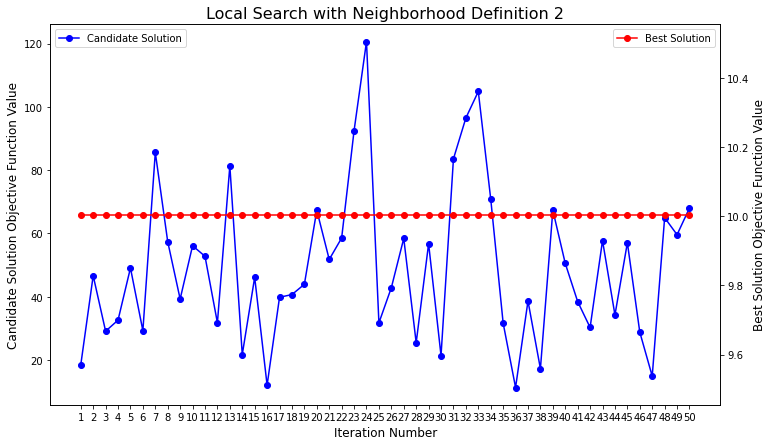

In [49]:
times, objectives, ngh, runs = [], [], [], []
for k in range(2,3):
    for i in range(1, n_run+1):
        print("neighborhood ", k, "run ", i)
        ngh.append(k)
        runs.append(i)
        local_search_average = LocalSearch(rg_, init_sol, n_iteration, wt_obj='average')
        local_search_average.run(which_neighbor=k)
        times.append(local_search_average.time)
        objectives.append(local_search_average.best_value)
        local_search_average.plot_ls(k, which_run=i)

In [50]:
Res = pd.DataFrame(columns=['Neighborhood','Run_n','BestObj','Time'])
Res['Neighborhood'] = ngh
Res['Run_n'] = runs
Res['BestObj'] = objectives
Res['Time'] = times
Res.to_excel("excel_files/local_search_w_different_ngh.xlsx")

## 2. SA with selected neighborhood

In [ ]:
selected_neighborhood = 1 # later to be changed

In [ ]:
times, objectives, runs = [], [], []
for i in range(1, n_run+1):
    print("run ", i)
    runs.append(i)
    simulated_annealing_average = SimulatedAnnealing(rg_, init_sol, n_iteration, "average")
    simulated_annealing_average.run(which_neighbor=selected_neighborhood)
    times.append(simulated_annealing_average.time)
    objectives.append(simulated_annealing_average.best_value)
    simulated_annealing_average.plot_sa(selected_neighborhood, which_run=i)

In [ ]:
Res = pd.DataFrame(columns=['Run_n','BestObj','Time'])
Res['Run_n'] = runs
Res['BestObj'] = objectives
Res['Time'] = times
Res.to_excel("excel_files/simulated_annealing_w_selected_ngh.xlsx")

## 3. VNS

In [ ]:
times, objectives, runs = [], [], []
for i in range(1, n_run+1):
    print("run ", i)
    runs.append(i)
    vns_average = VNS(rg_, init_sol, n_iteration, "average")
    vns_average.run()
    times.append(vns_average.time)
    objectives.append(vns_average.best_value)
    vns_average.plot_vns(which_run=i)

In [ ]:
Res = pd.DataFrame(columns=['Run_n','BestObj','Time'])
Res['Run_n'] = runs
Res['BestObj'] = objectives
Res['Time'] = times
Res.to_excel("excel_files/vns.xlsx")

## 4. Local Search with Random Initial Solution

In [ ]:
init_sol = getRandomFeasibleSolution("average")

In [ ]:
times, objectives, runs = [], [], []
for i in range(1, n_run+1):
    print("run ", i)
    runs.append(i)
    local_search_average = LocalSearch(rg_, init_sol, n_iteration, wt_obj='average')
    local_search_average.run(which_neighbor=selected_neighborhood)
    times.append(local_search_average.time)
    objectives.append(local_search_average.best_value)
    local_search_average.plot_ls(selected_neighborhood, which_run=i, randomm_init_sol=True)

In [ ]:
Res = pd.DataFrame(columns=['Run_n','BestObj','Time'])
Res['Run_n'] = runs
Res['BestObj'] = objectives
Res['Time'] = times
Res.to_excel("excel_files/rnd_local_search_w_selected_ngh.xlsx")

## 5. Simulated Annealing with Random Initial Solution

In [ ]:
times, objectives, runs = [], [], []
for i in range(1, n_run+1):
    print("run ", i)
    runs.append(i)
    simulated_annealing_average = SimulatedAnnealing(rg_, init_sol, n_iteration, "average")
    simulated_annealing_average.run(which_neighbor=selected_neighborhood)
    times.append(simulated_annealing_average.time)
    objectives.append(simulated_annealing_average.best_value)
    simulated_annealing_average.plot_sa(selected_neighborhood, which_run=i, randomm_init_sol=True)

In [ ]:
Res = pd.DataFrame(columns=['Run_n','BestObj','Time'])
Res['Run_n'] = runs
Res['BestObj'] = objectives
Res['Time'] = times
Res.to_excel("excel_files/rnd_simulated_annealing_w_selected_ngh.xlsx")

## 6. VNS with Random Initial Solution

In [ ]:
times, objectives, runs = [], [], []
for i in range(1, n_run+1):
    print("run ", i)
    runs.append(i)
    vns_average = VNS(rg_, init_sol, n_iteration, "average")
    vns_average.run()
    times.append(vns_average.time)
    objectives.append(vns_average.best_value)
    vns_average.plot_vns(which_run=i, randomm_init_sol=True)

In [ ]:
Res = pd.DataFrame(columns=['Run_n','BestObj','Time'])
Res['Run_n'] = runs
Res['BestObj'] = objectives
Res['Time'] = times
Res.to_excel("excel_files/rnd_vns.xlsx")

## 7. Multi-Objective Local Search & VNS

In [ ]:
init_sol = constructionHeuristic("average")

In [ ]:
times_LS, times_VNS, SM_LS, SM_VNS, Dm_LS, Dm_VNS, QM_LS, QM_VNS, runs = [], [], [], [], [], [], [],[],[]
for i in range(1, n_run+1):
    print("run ", i)
    runs.append(i)
    
    local_search_multi = LocalSearchMultiObj(rg_, init_sol, n_iteration,wt_obj="average")
    local_search_multi.run(which_neighbor=selected_neighborhood)
    times_LS.append(local_search_multi.time)
    sm_, dm_ = SM_DM(local_search_multi)
    SM_LS.append(sm_)
    Dm_LS.append(dm_)
    
    vns_multi = VNSMultiObj(rg_, init_sol, n_iteration,wt_obj="average")
    vns_multi.run()
    times_VNS.append(local_search_multi.time)
    sm_, dm_ = SM_DM(vns_multi)
    SM_VNS.append(sm_)
    Dm_VNS.append(dm_)
    
    ls_QM, vns_QM = QM(local_search_multi,vns_multi)
    QM_LS.append(ls_QM)
    QM_VNS.append(vns_QM)
    
    local_search_multi.plot(which_neighbor=selected_neighborhood, which_run=i)
    vns_multi.plot(which_run=i)

In [ ]:
Res = pd.DataFrame(columns=['Run_n','LS_SM','LS_DM','LS_QM','LS_Time','VNS_SM','VNS_DM','VNS_QM','VNS_Time'])
Res['Run_n'] = runs
Res['LS_SM'] = SM_LS
Res['LS_DM'] = Dm_LS
Res['LS_QM'] = QM_LS
Res['LS_Time'] = times_LS
Res['VNS_SM'] = SM_VNS
Res['VNS_DM'] = Dm_VNS
Res['VNS_QM'] = QM_VNS
Res['VNS_Time'] = times_VNS
Res.to_excel("excel_files/multiobjective.xlsx")